### 2. Calcular el número de 1-pixeles

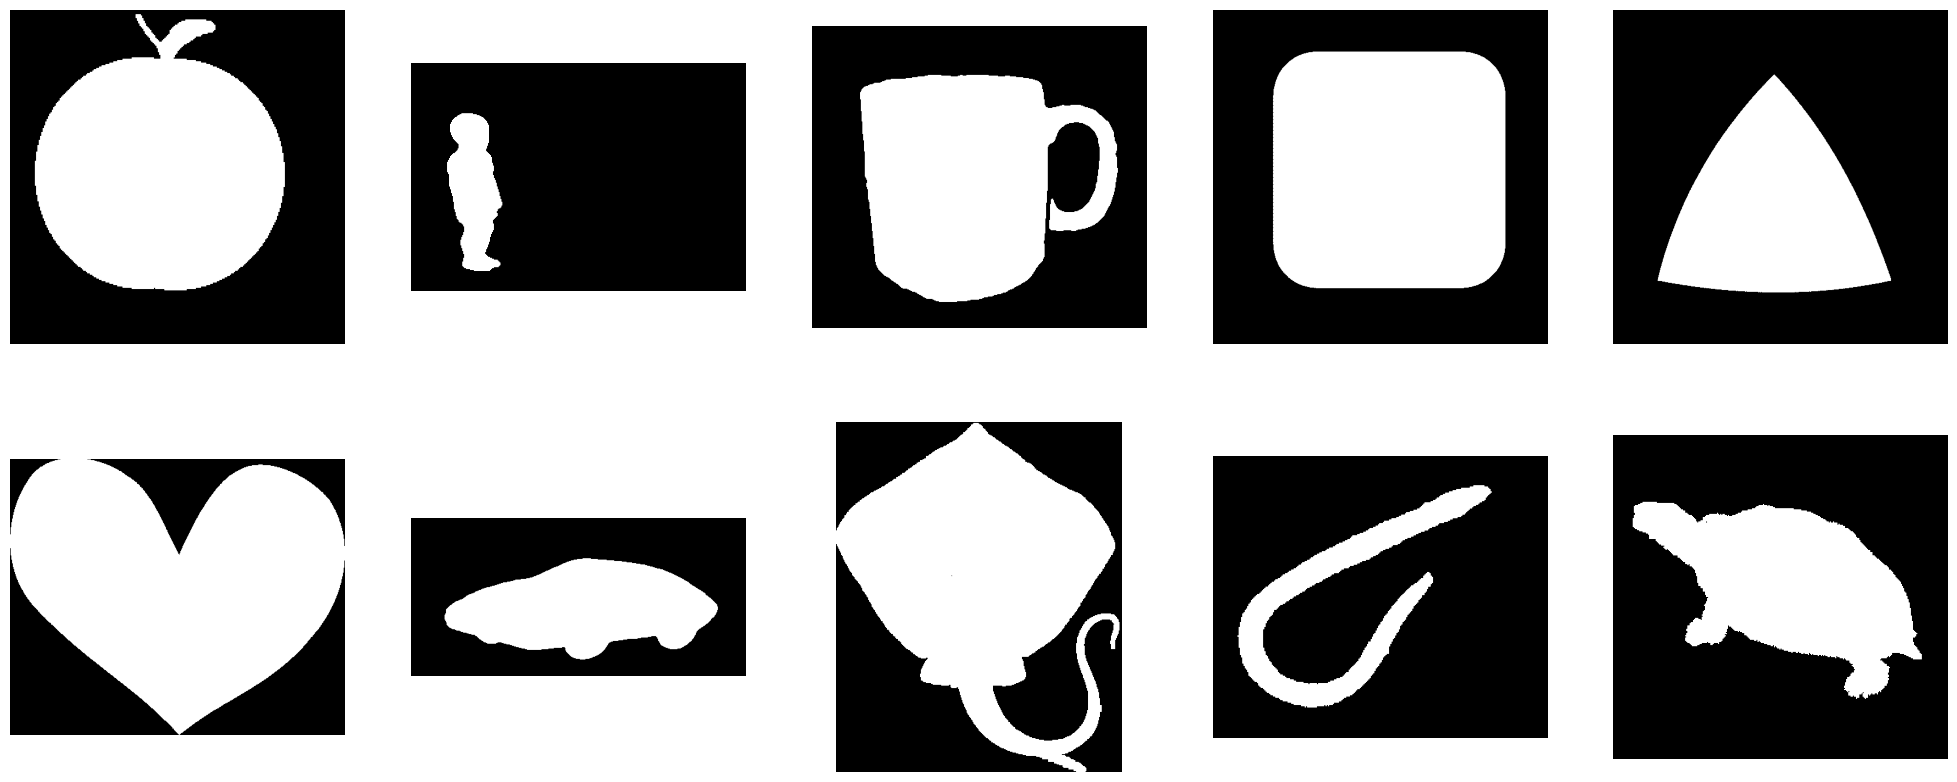

In [47]:
import plotly.graph_objects as go
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import pandas as pd

names = ['apple-1.png', 'children-1.png', 'cup-1.png', 'device3-1.png', 
         'device4-1.png', 'Heart-1.png', 'personal_car-1.png', 'ray-1.png', 'sea_snake-1.png','turtle-1.png']

images = []
 
# Cargar y guardar las imagenes binarias
for name in names:
    fullName = 'images/' + name
    img = np.array(cv2.imread(fullName, cv2.IMREAD_GRAYSCALE))/255
    images.append(img.astype(int))

def showImages(images):
    fig,axs = plt.subplots(2,5,figsize=(25,10))
    for i,img in enumerate(images):
        row = i//5
        col = i%5
        axs[row,col].imshow(img,cmap = "Greys_r")
        axs[row,col].axis("off")
    plt.show()
showImages(images)


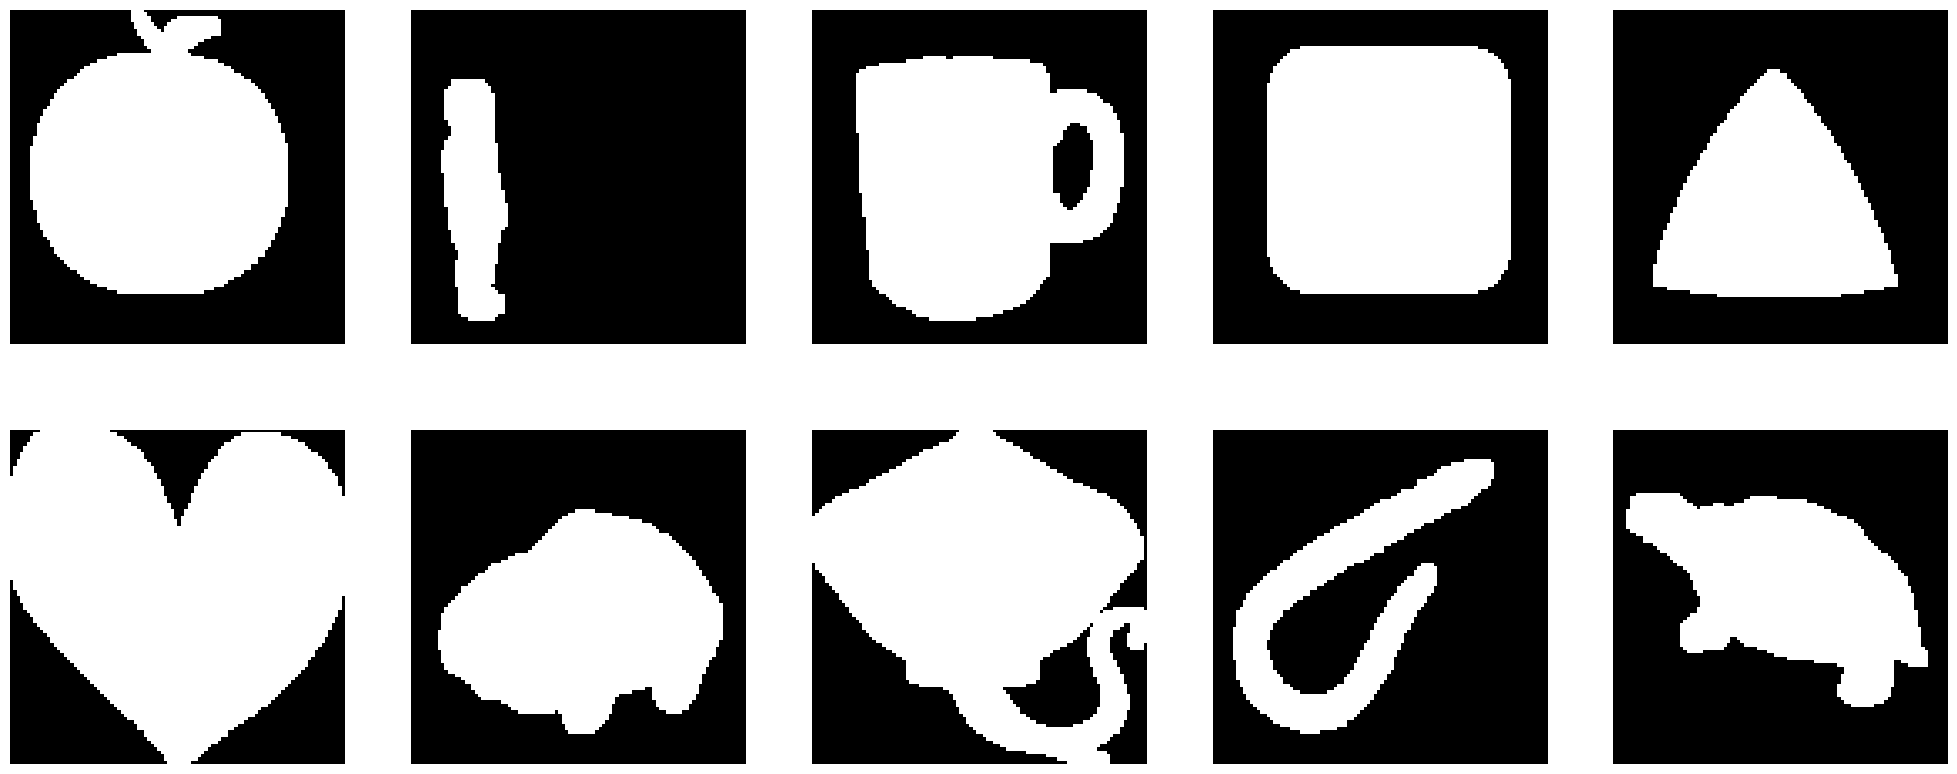

In [48]:
resized_images = []
for image in images:
    resized_image = np.array(skimage.transform.resize(image,(100,100)))
    resized_image[resized_image != 0] = 1
    resized_images.append(resized_image)

showImages(resized_images)

In [49]:
def count_one_pixels(image):
    return np.count_nonzero(image)

n_pixels = []
for image in resized_images:
    n_pixels.append(count_one_pixels(image))

fig = go.Figure(data=[go.Table(header=dict(values=['Imagen', 'Cantidad de 1-píxeles'], line_color='darkslategray',
                fill_color='gray', font=dict(color='white', size=12)),
                cells=dict(values=[names, n_pixels], line_color='darkslategray',
                fill_color='lightgray', font=dict(color='black', size=12)))])
fig.show()

count_one_pixels(resized_images)

41756

### 3. Transformaciones de escala

In [50]:
def calculate_center_of_mass(image):
    M = np.sum(image)
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    Xcm = np.sum(x * image) / M
    Ycm = np.sum(y * image) / M
    return int(np.floor(Xcm)), int(np.floor(Ycm))

In [51]:
def scale_object(image, center_of_mass, scale_factor):
    # Crear matriz de coordenadas
    coords = np.array(np.where(image)).T
    
    # Restar centro de masa a coordenadas
    coords_centered = coords - center_of_mass
    
    # Escalar coordenadas
    scaled_coords = coords_centered * scale_factor
    
    # Sumar centro de masa a coordenadas escaladas
    scaled_coords += center_of_mass
    
    # Crear imagen vacía para la imagen escalada
    scaled_image = np.zeros_like(image)
    
    # Convertir coordenadas escaladas en índices de imagen
    indices = np.round(scaled_coords).astype(int)
    
    # Asegurarse de que los índices estén dentro de los límites de la imagen
    indices[:, 0] = np.clip(indices[:, 0], 0, image.shape[1]-1)
    indices[:, 1] = np.clip(indices[:, 1], 0, image.shape[0]-1)
    
    # Establecer píxeles en la imagen escalada
    scaled_image[indices[:, 0], indices[:, 1]] = 1

    scaled_image[scaled_image != 0] = 1
    
    return scaled_image

1119
1060
1098
1066
1088
1102
1095
1144
1108
1102


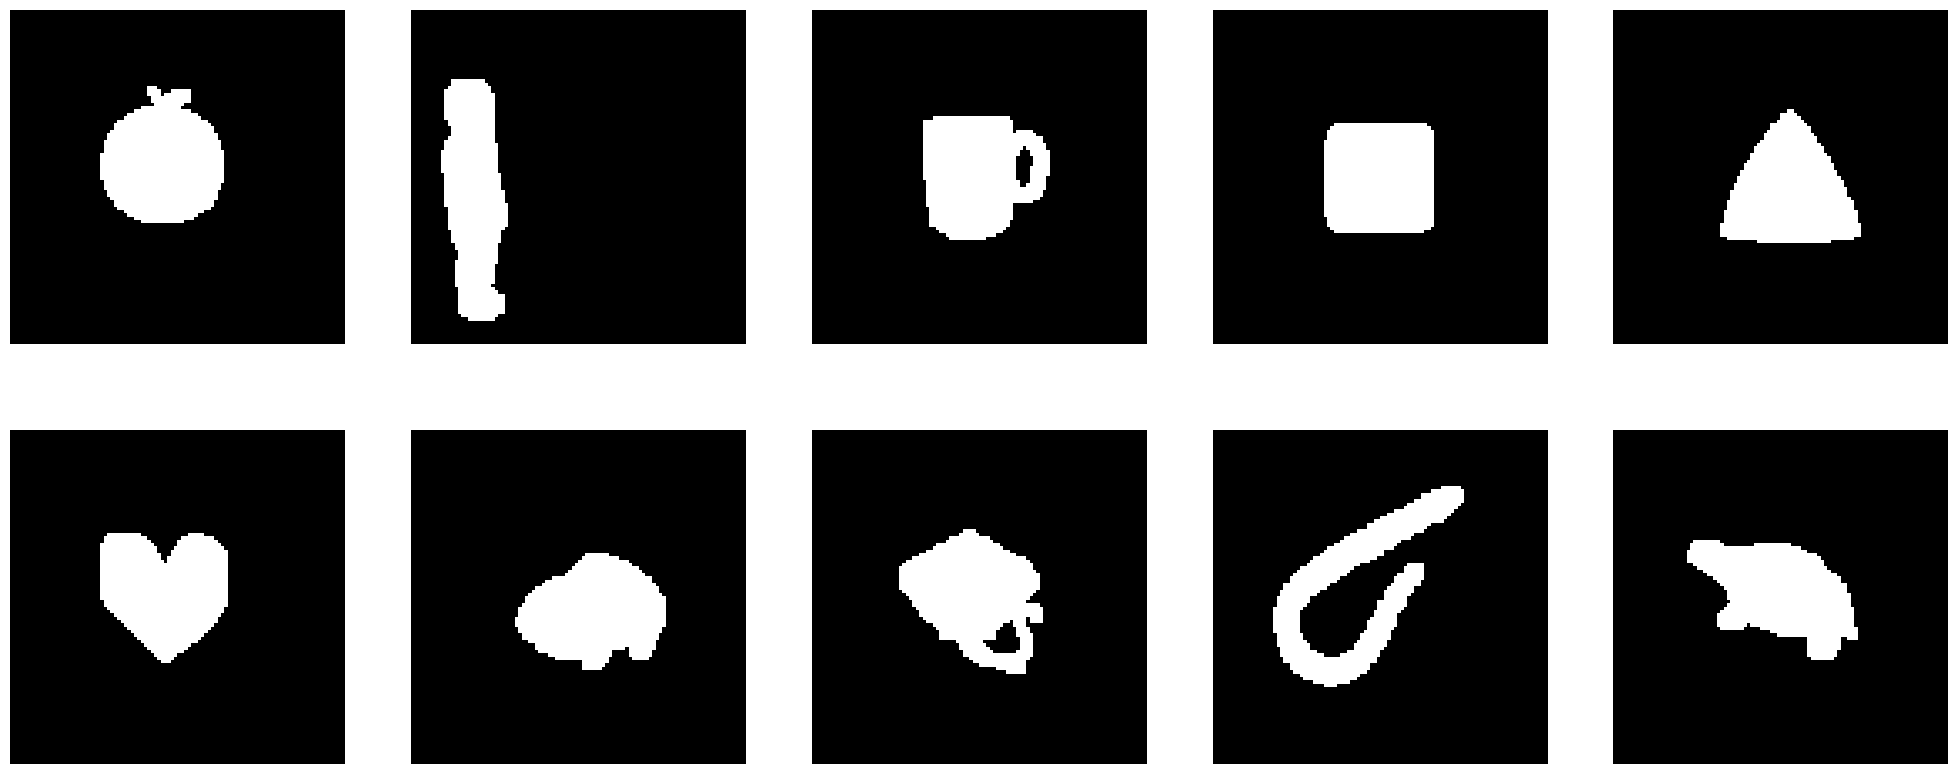

In [52]:
scaled_images = []

min = np.min(n_pixels)
for i in range(len(resized_images)):
   factor = math.sqrt(min / n_pixels[i])
   scaled_images.append(scale_object(resized_images[i], calculate_center_of_mass(resized_images[i]), factor))

for image in scaled_images:
   print(np.count_nonzero(image))

showImages(scaled_images)

### 4. Invariante de escala siguiente, antes y después del escalamiento con p,q = 0,1 y 2

$$
\mu_{pq} = \sum_{x=1}^{M}\sum_{y=1}^{N} (x - x_{cm})^p (y - y_{cm})^q
$$

$$
\eta_{pq} = \frac{\mu_{pq}}{\mu_{00}^{\frac{p + q}{2} + 1}}
$$

In [53]:
def central_moment(image, p, q):
    x_cm, y_cm = calculate_center_of_mass(image)
    sum = 0
    for Y in range(image.shape[0]):
        for X in range(image.shape[1]):
            if (image[Y, X] != 0):
                sum += (X - x_cm) ** p * (Y - y_cm) ** q
    return sum

def normalized_moments(image, p, q):
    mu_pq = central_moment(image, p, q)
    mu_00 = central_moment(image, 0, 0)
    eta_pq = mu_pq / (mu_00**((p+q)/2 + 1))
    return eta_pq

for i in range(len(resized_images)):
    print('Imagen original', i + 1)
    for p in range(0, 3):
        q_values = []
        for q in range(0, 3):
            result = normalized_moments(resized_images[i], p, q)
            q_values.append(result)
        print(q_values)
    print('Imagen escalada', i + 1)
    for p in range(0, 3):
        q_values = []
        for q in range(0, 3):
            result = normalized_moments(scaled_images[i], p, q)
            q_values.append(result)
        print(q_values)
    print()

Imagen original 1
[1.0, 0.010072944972135098, 0.08506696018685066]
[0.004735119570728199, -0.0011842895111278155, 0.001181487087527688]
[0.07737399661735886, 0.0025800849364796185, 0.0042499730309552425]
Imagen escalada 1
[1.0, 0.0010418842603521937, 0.08658870544602491]
[0.006518455372459878, -0.0009112246747822365, 0.0013701037056289276]
[0.0757011278901036, 0.002114971809544705, 0.004128560132374518]

Imagen original 2
[1.0, 0.015792020692193556, 0.36589622641509434]
[0.010228593218980413, 0.01861694553221787, 0.005301767057658916]
[0.01965557137771449, 6.505973558494143e-05, 0.006098774491694486]
Imagen escalada 2
[1.0, 0.015792020692193556, 0.36589622641509434]
[0.010228593218980413, 0.01861694553221787, 0.005301767057658916]
[0.01965557137771449, 6.505973558494143e-05, 0.006098774491694486]

Imagen original 3
[1.0, 0.00993250253257388, 0.08902992794527399]
[0.010925454602026628, -0.002730480423352363, -0.0024708904912734467]
[0.08364162826418912, -0.0025144672096222096, 0.0054251

### 5. Obtener gráficos de las celdas (cuadrangulares) de resolución de los 1-pixeles

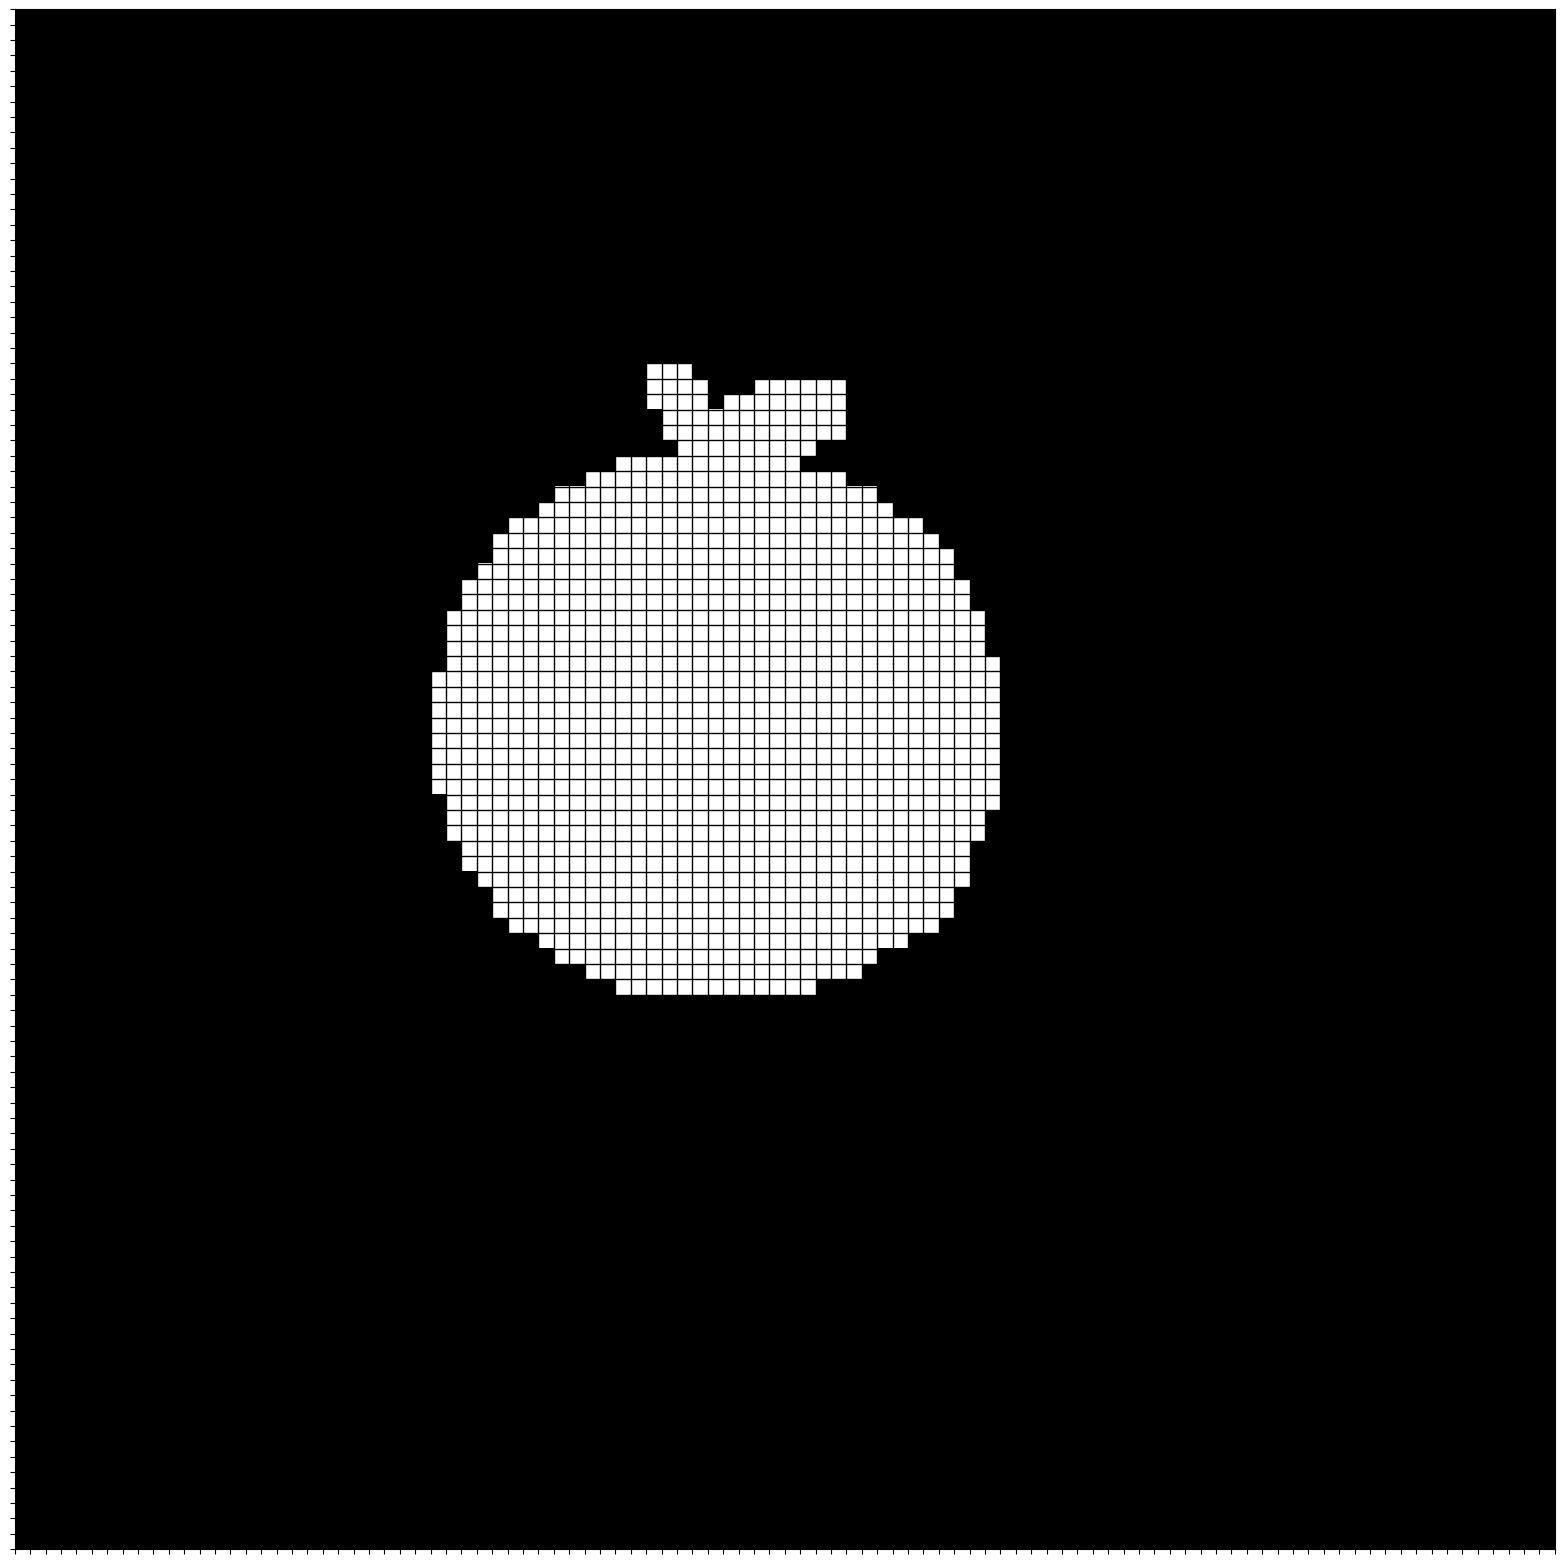

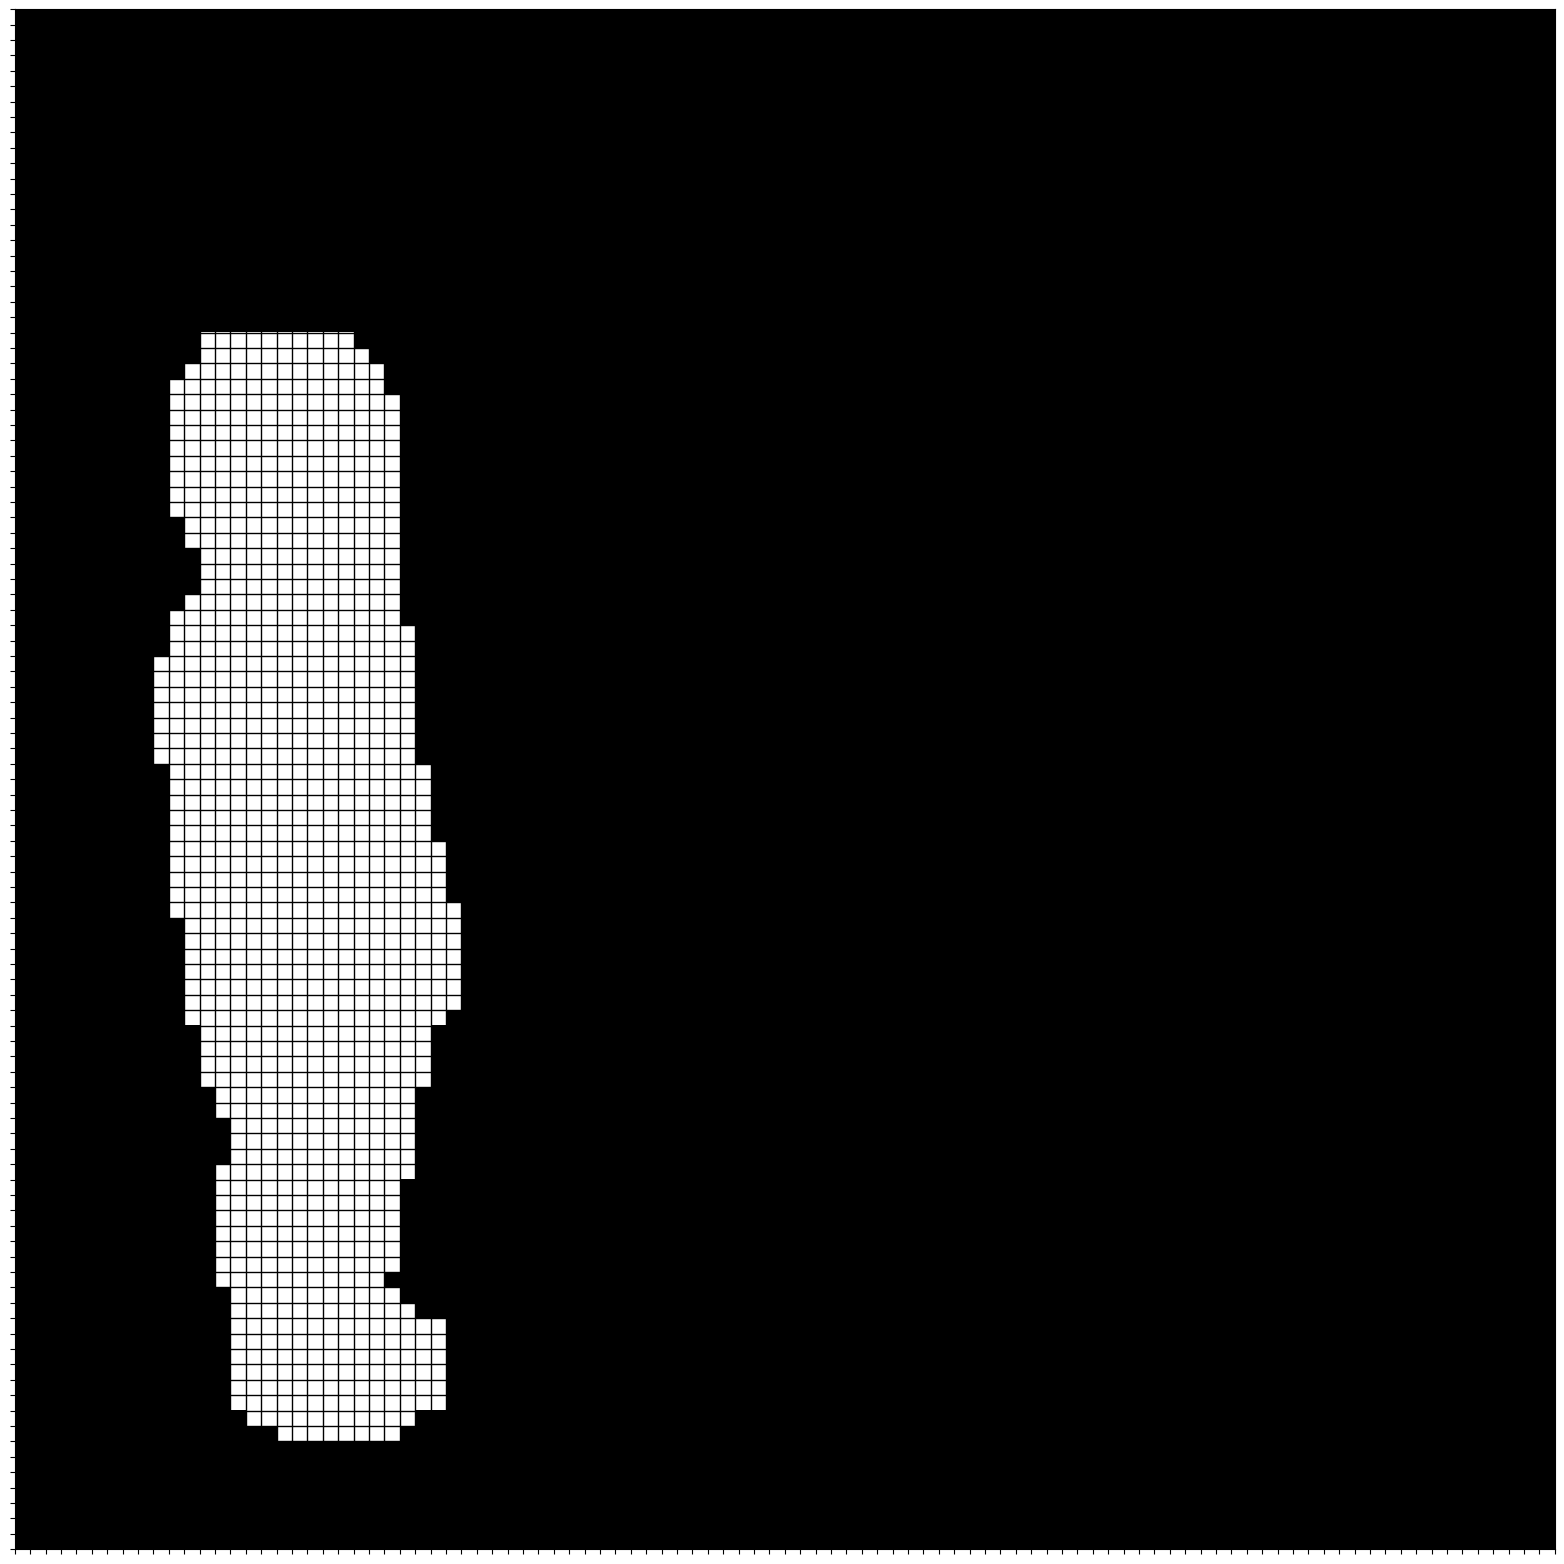

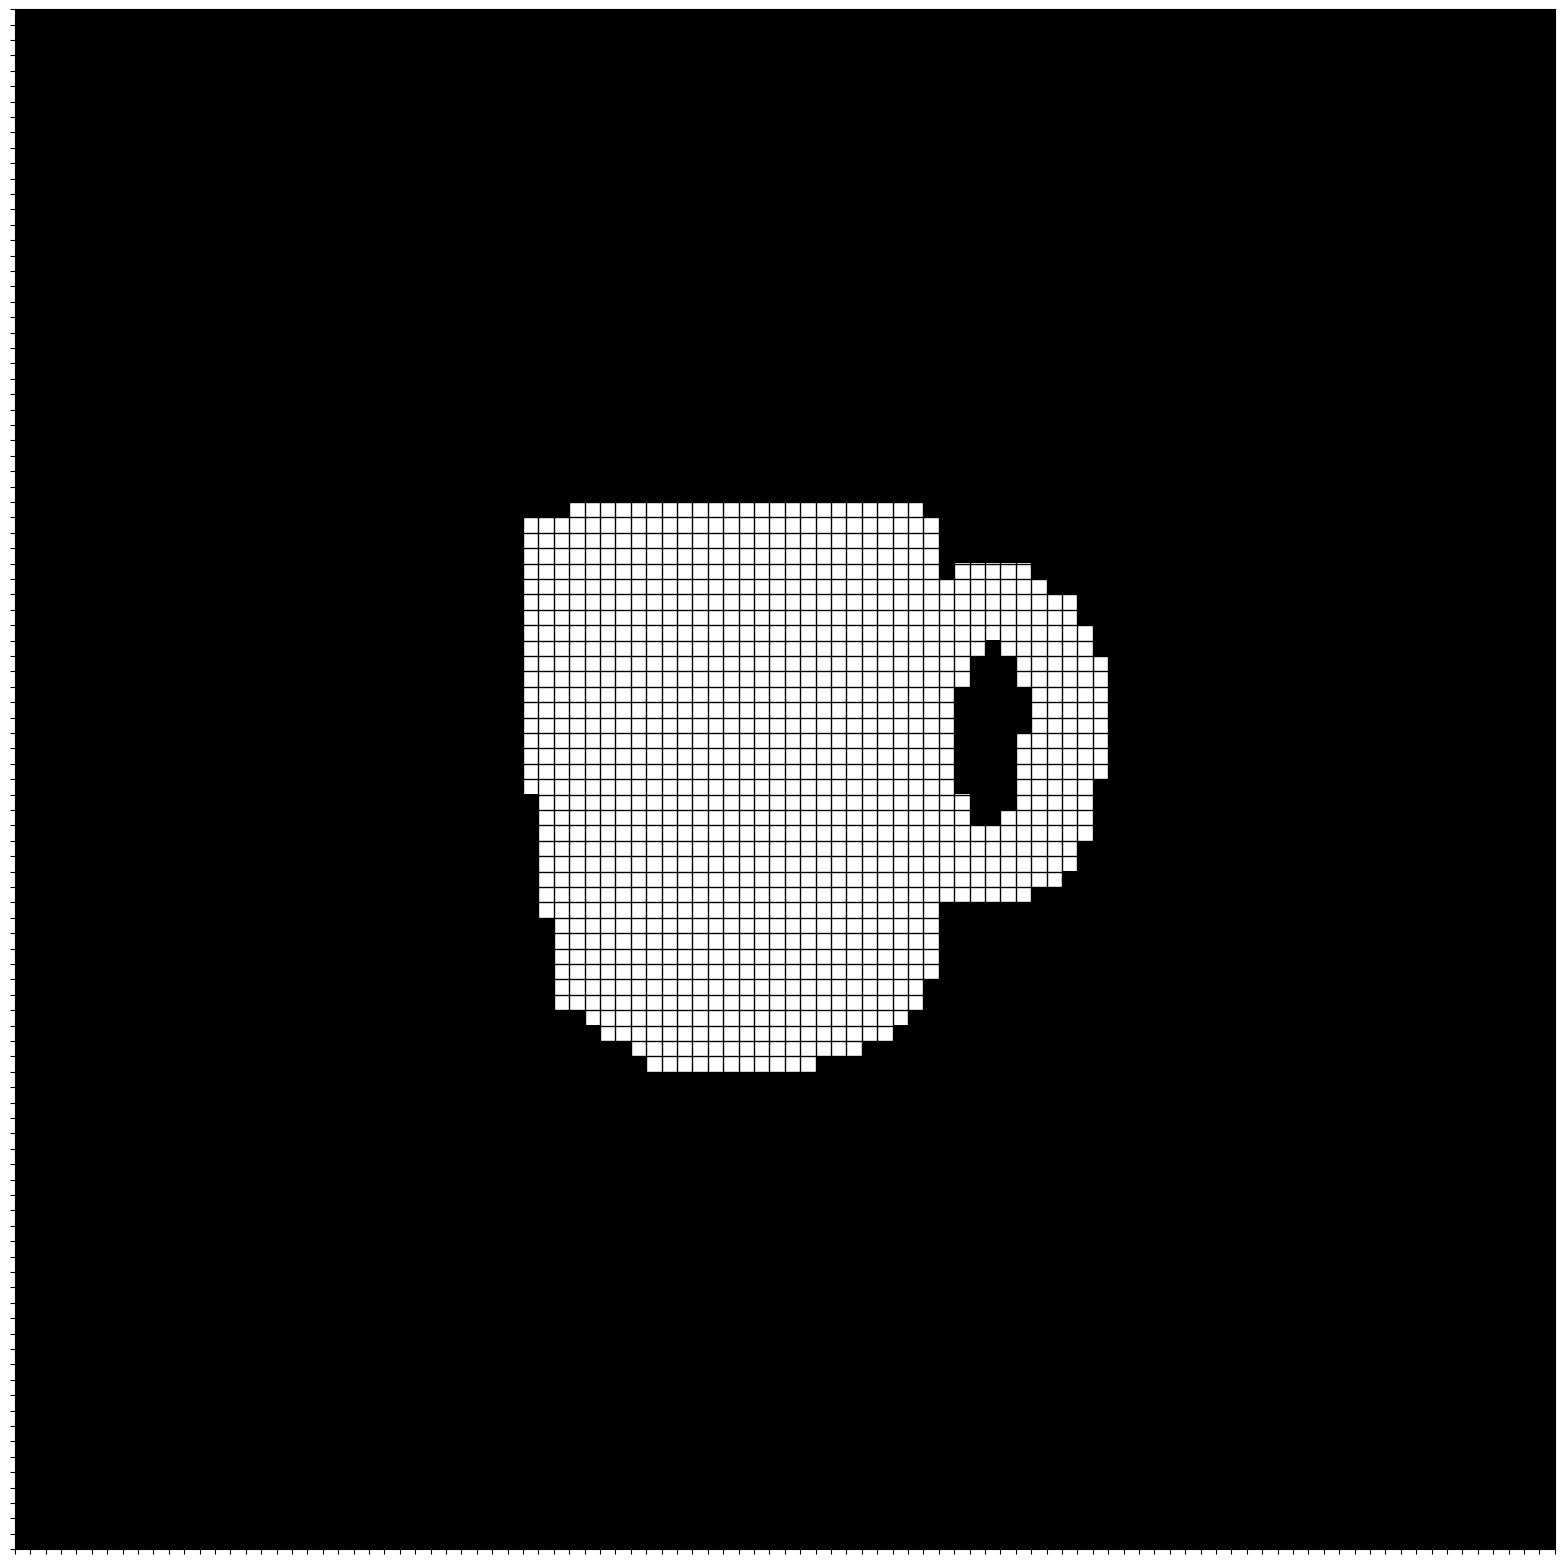

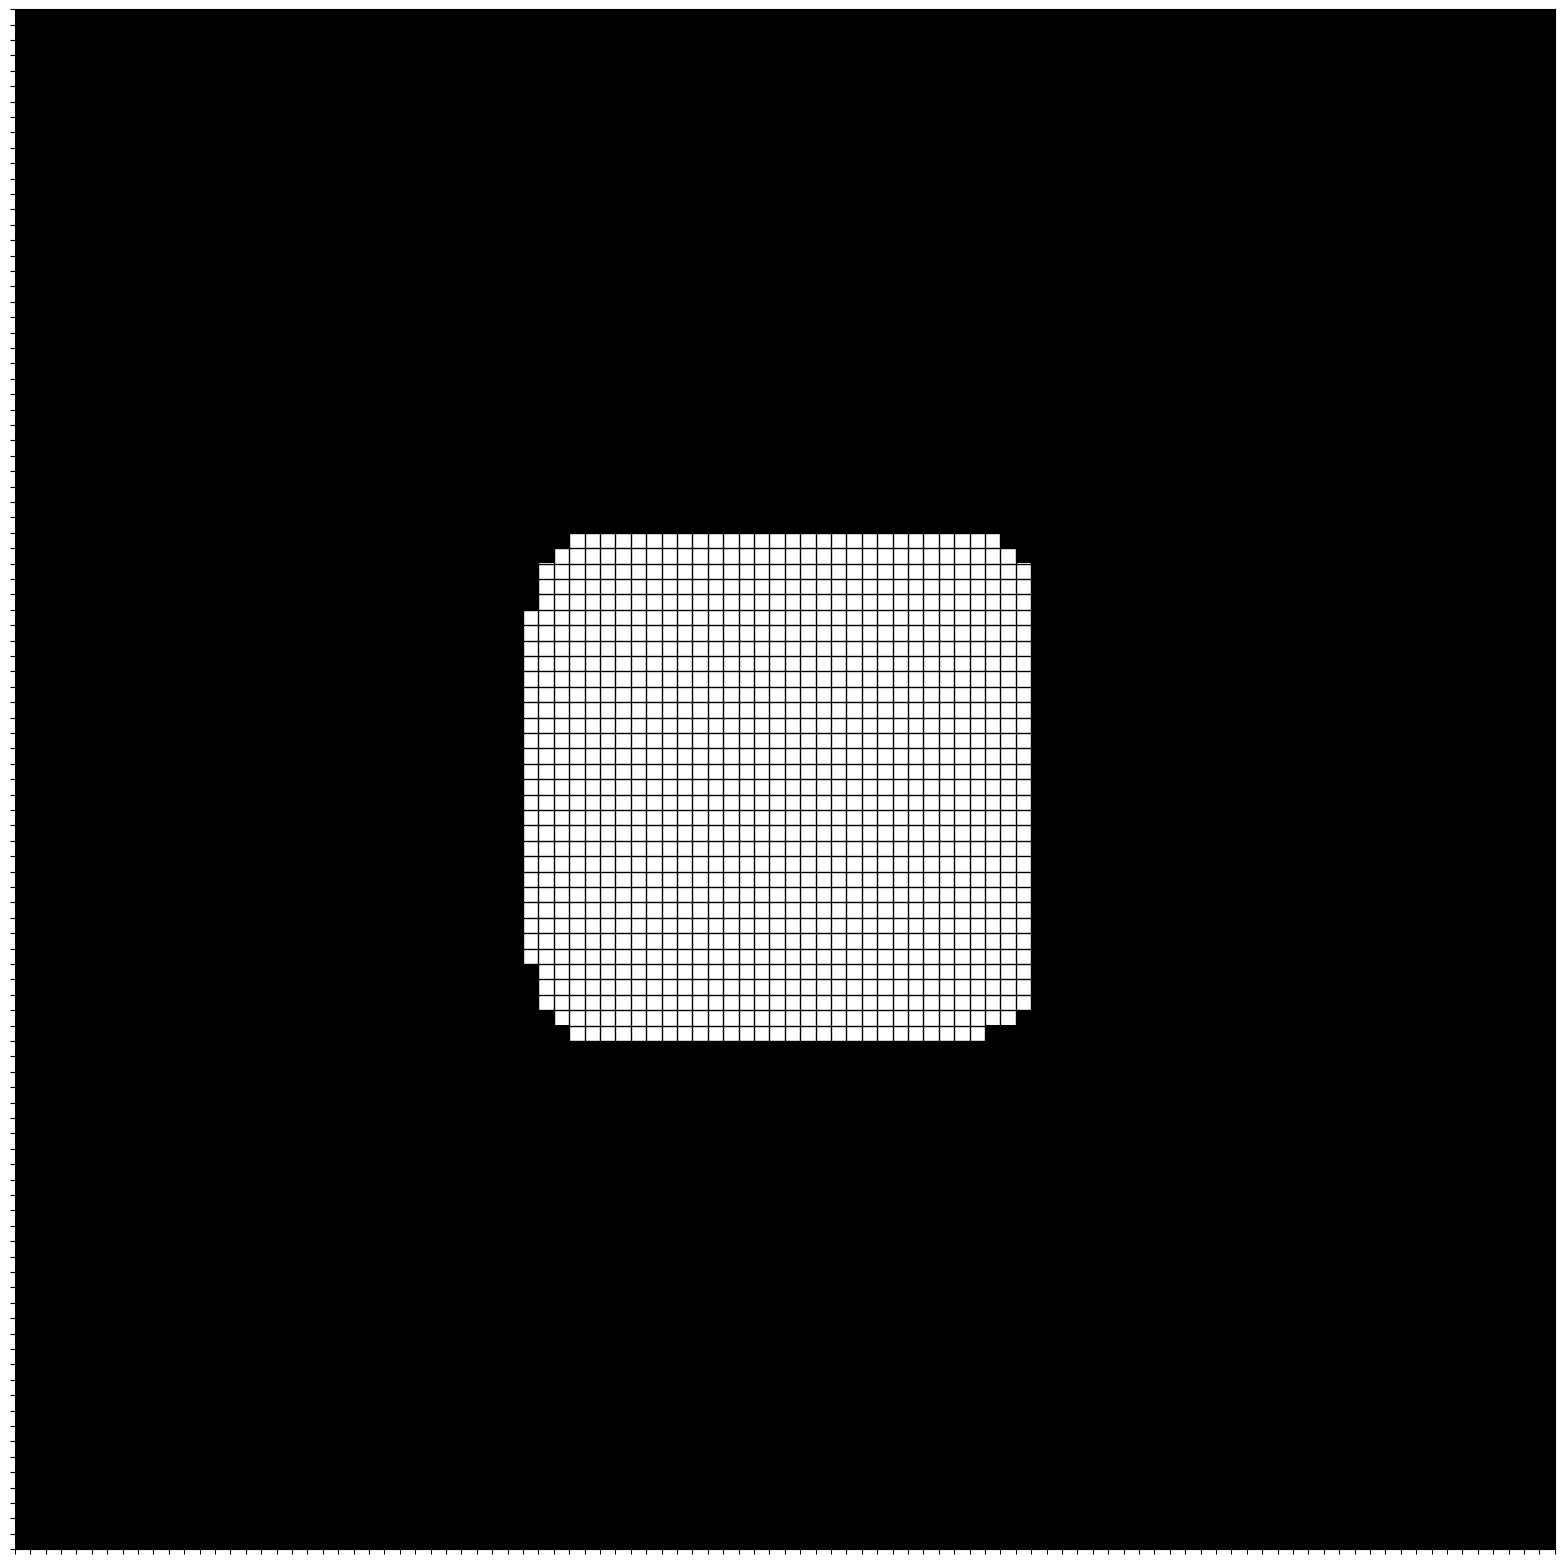

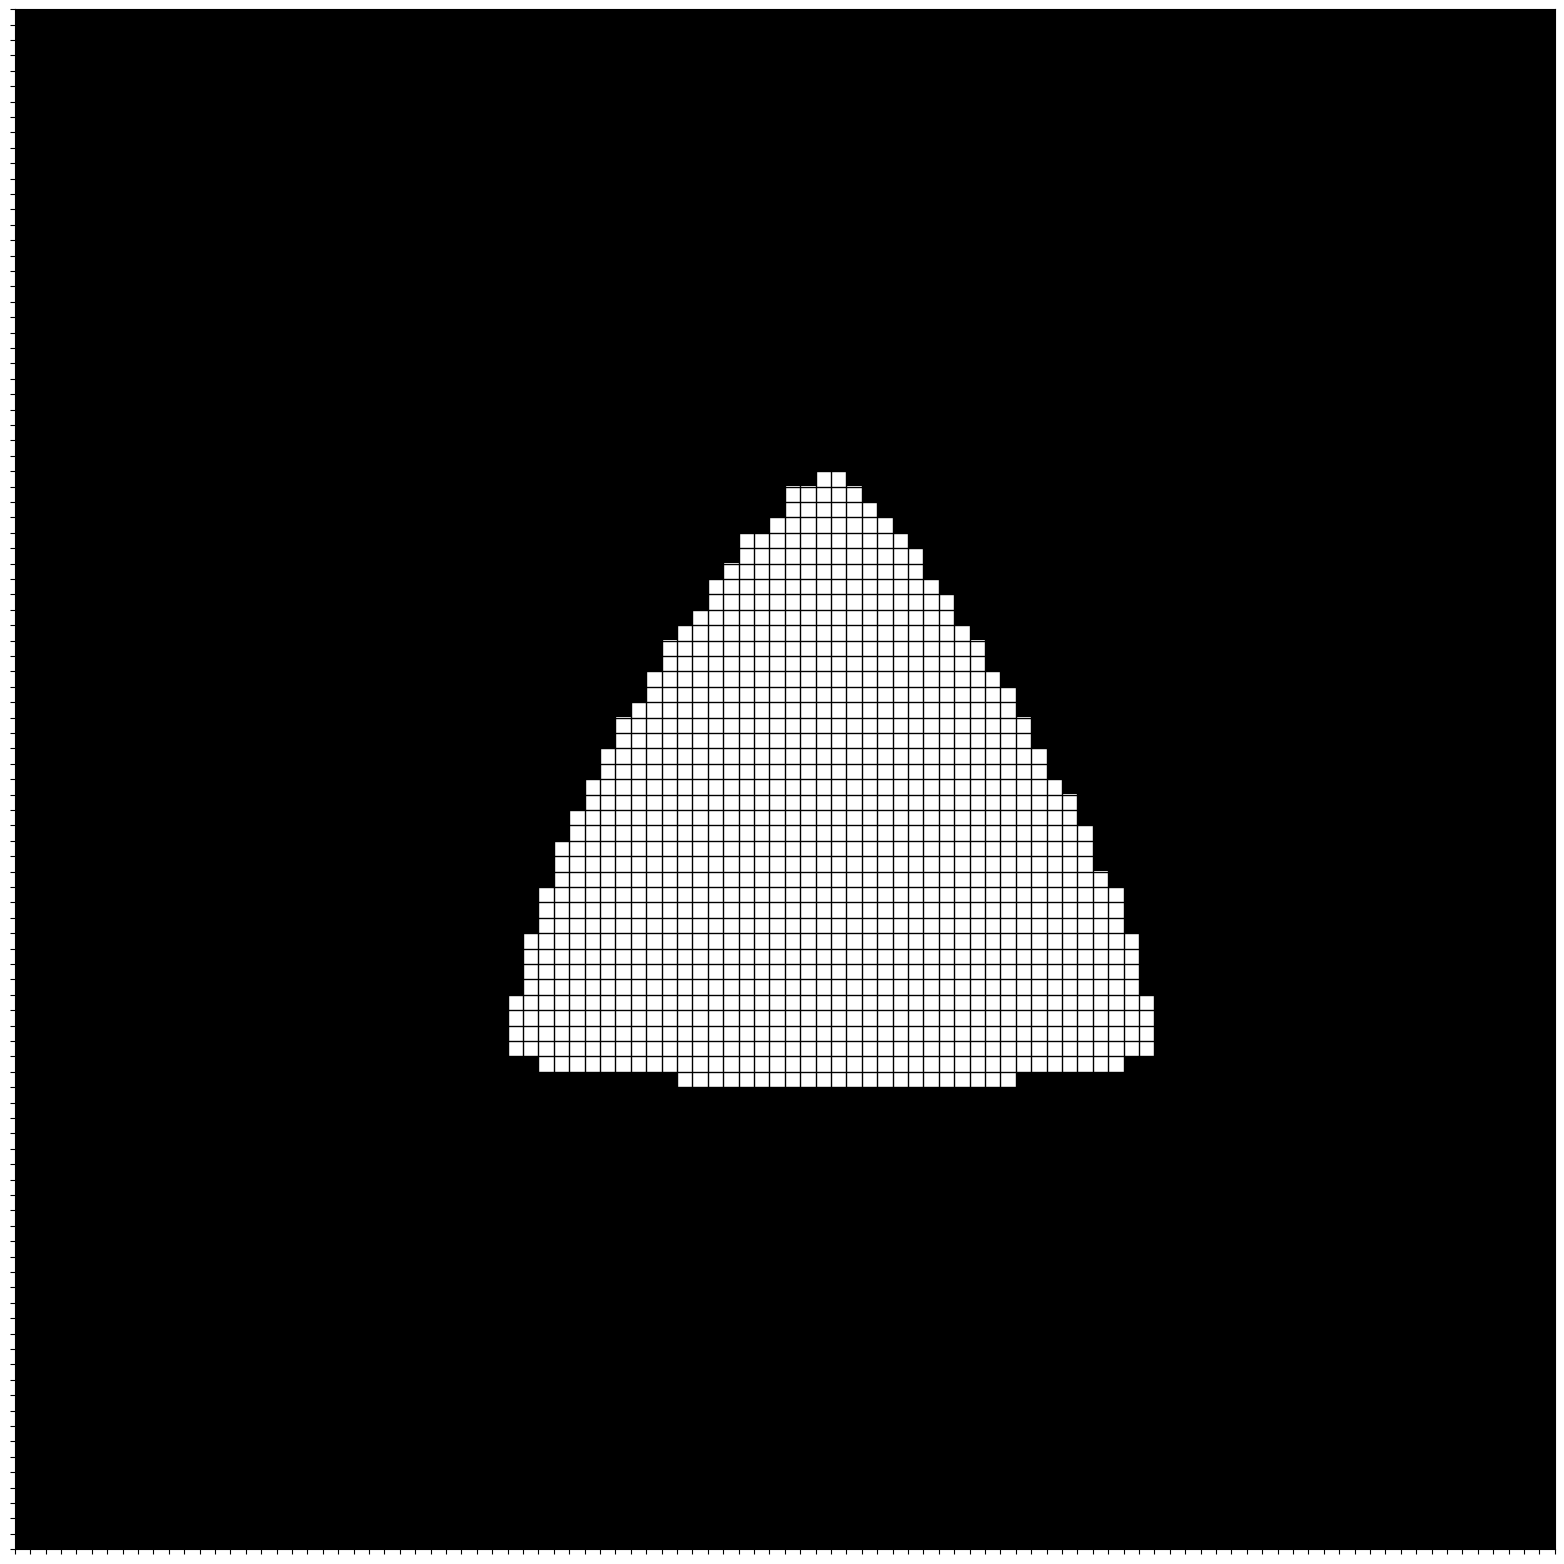

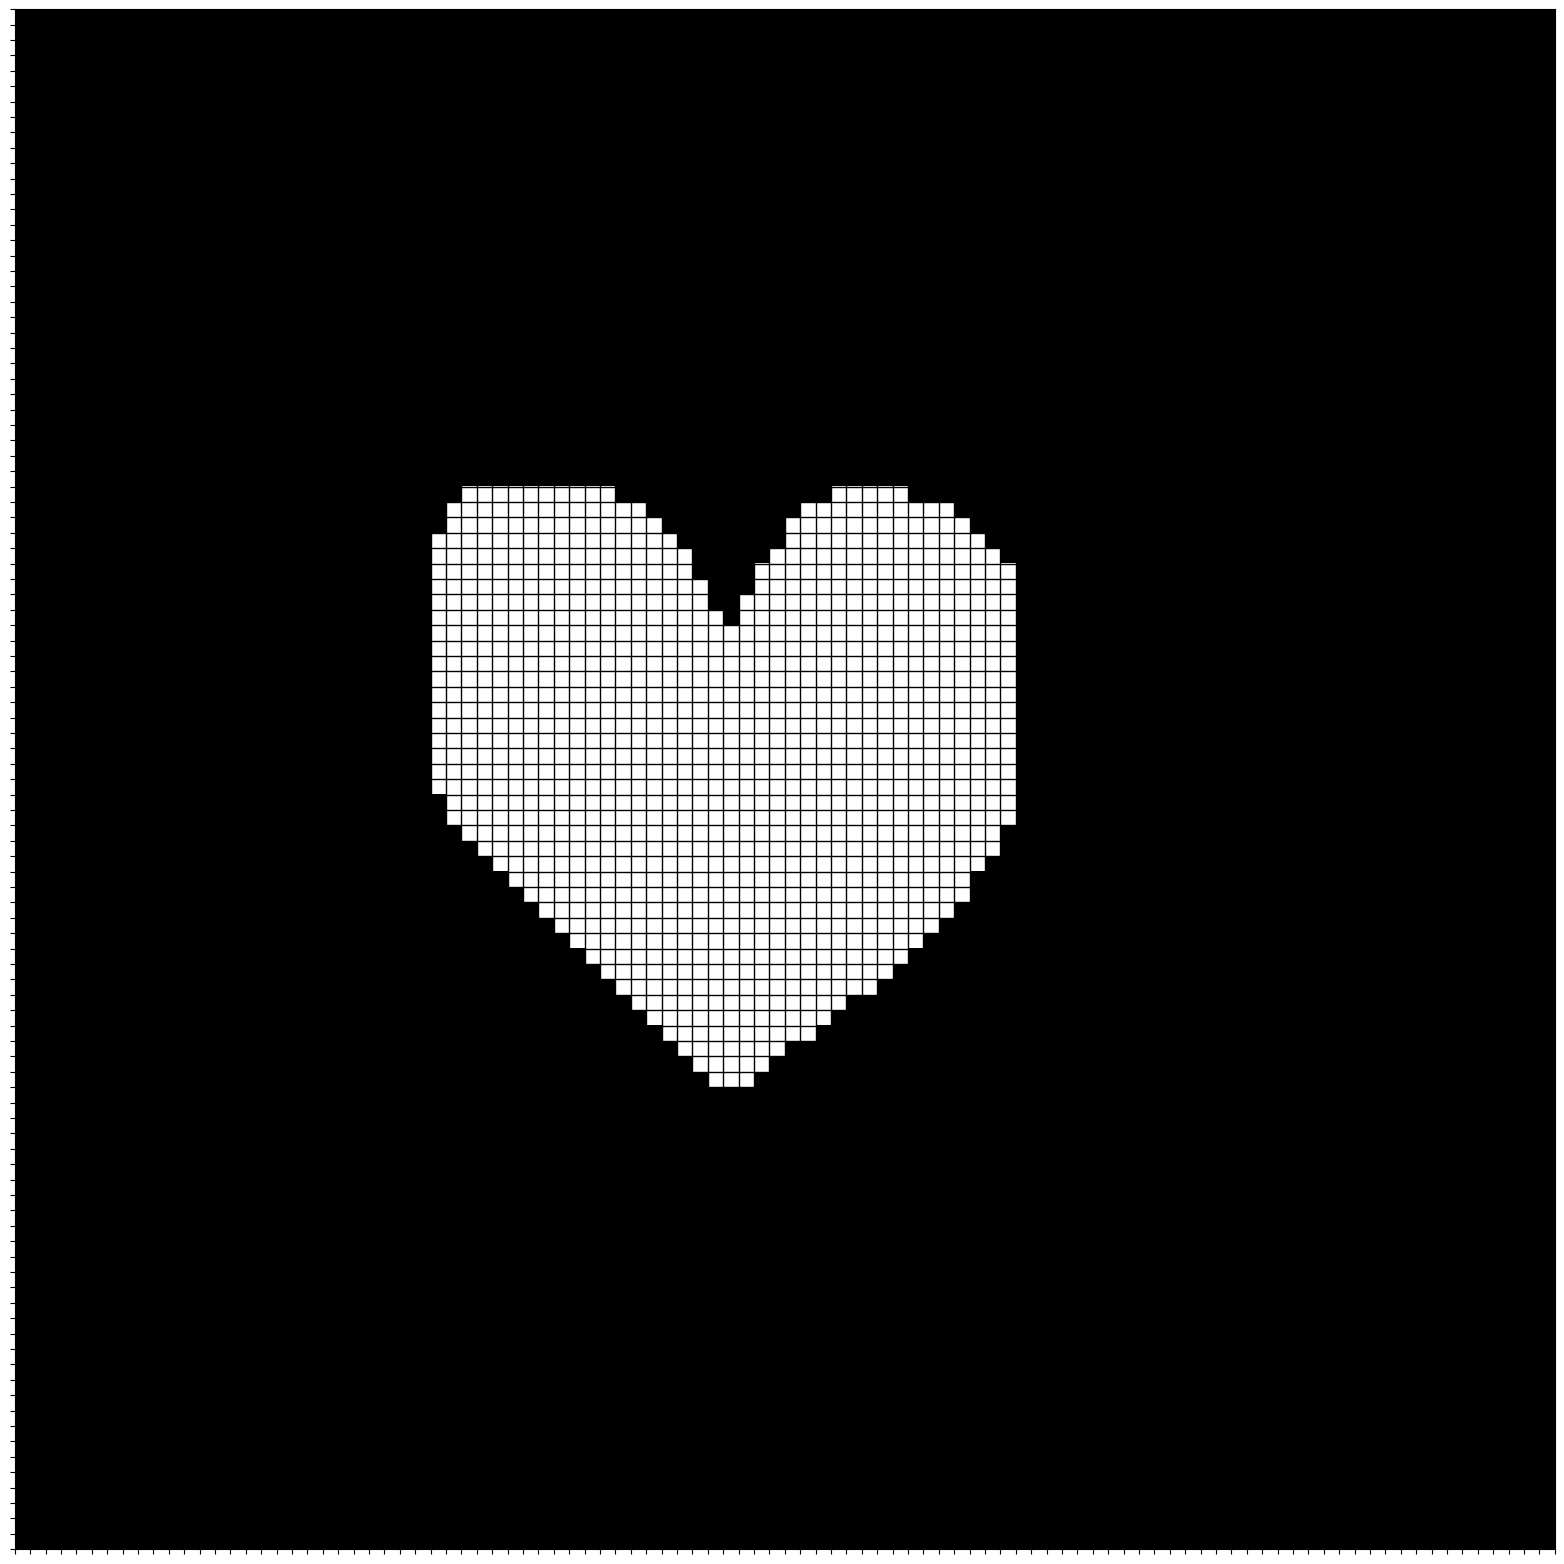

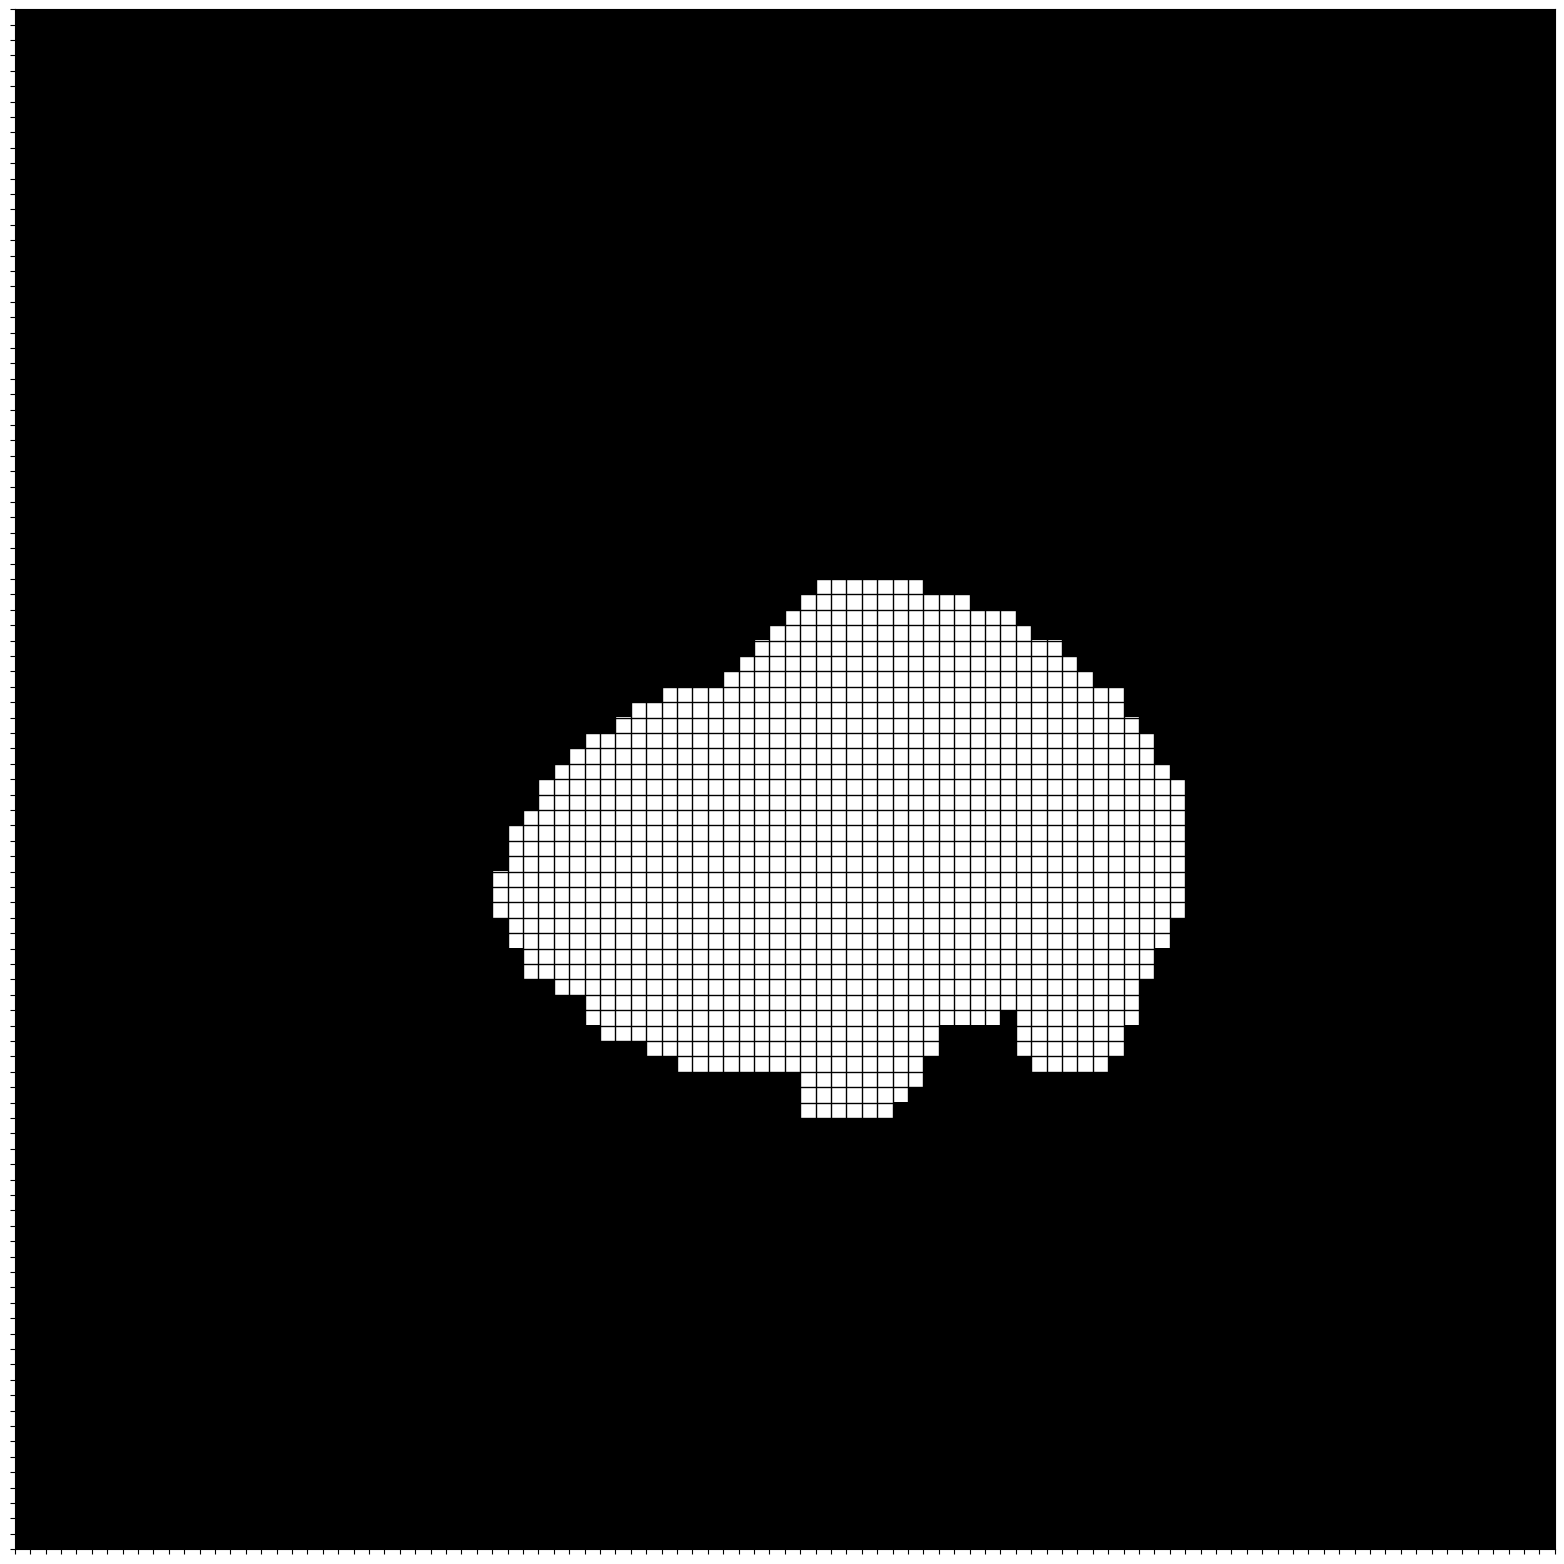

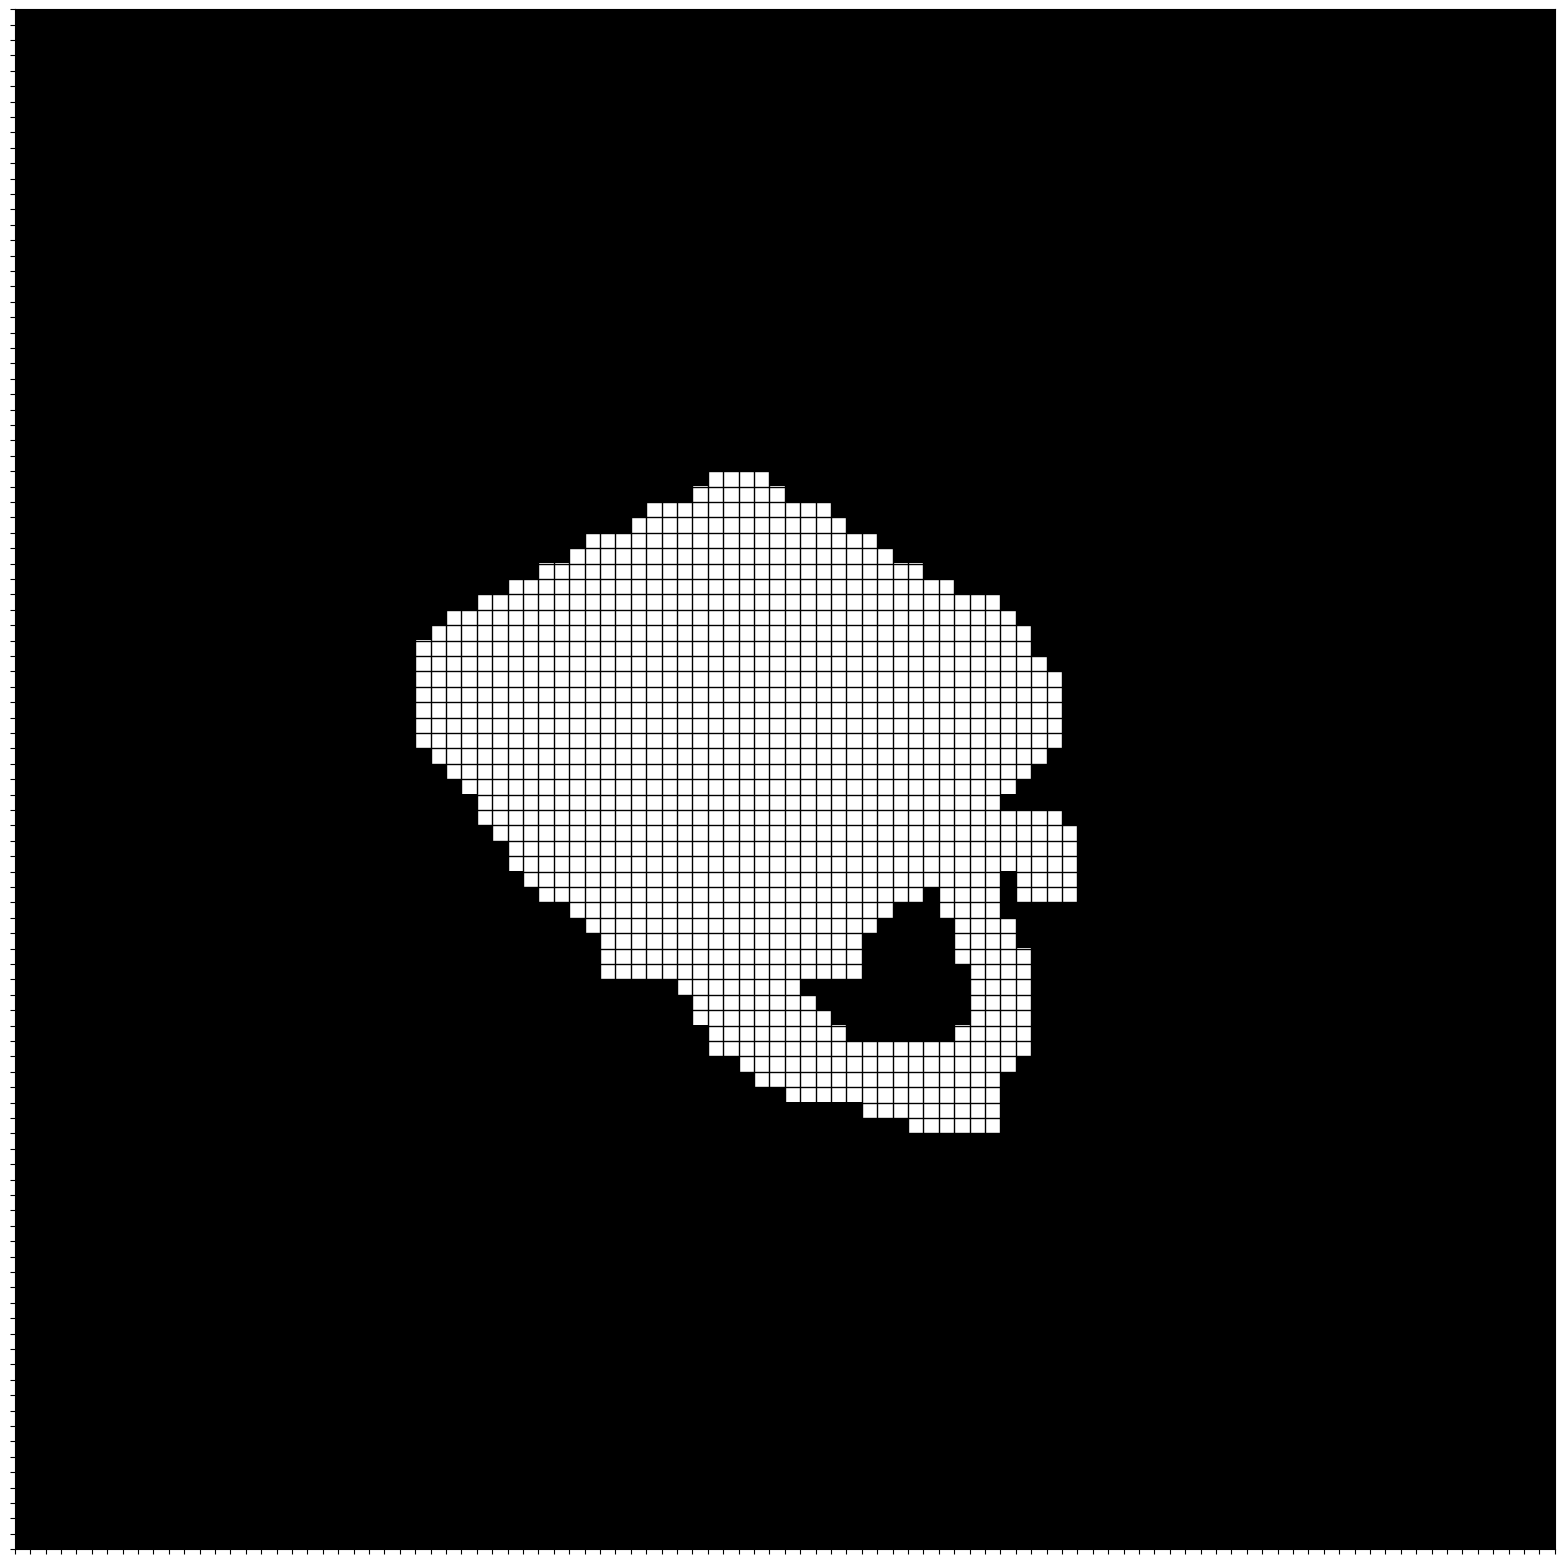

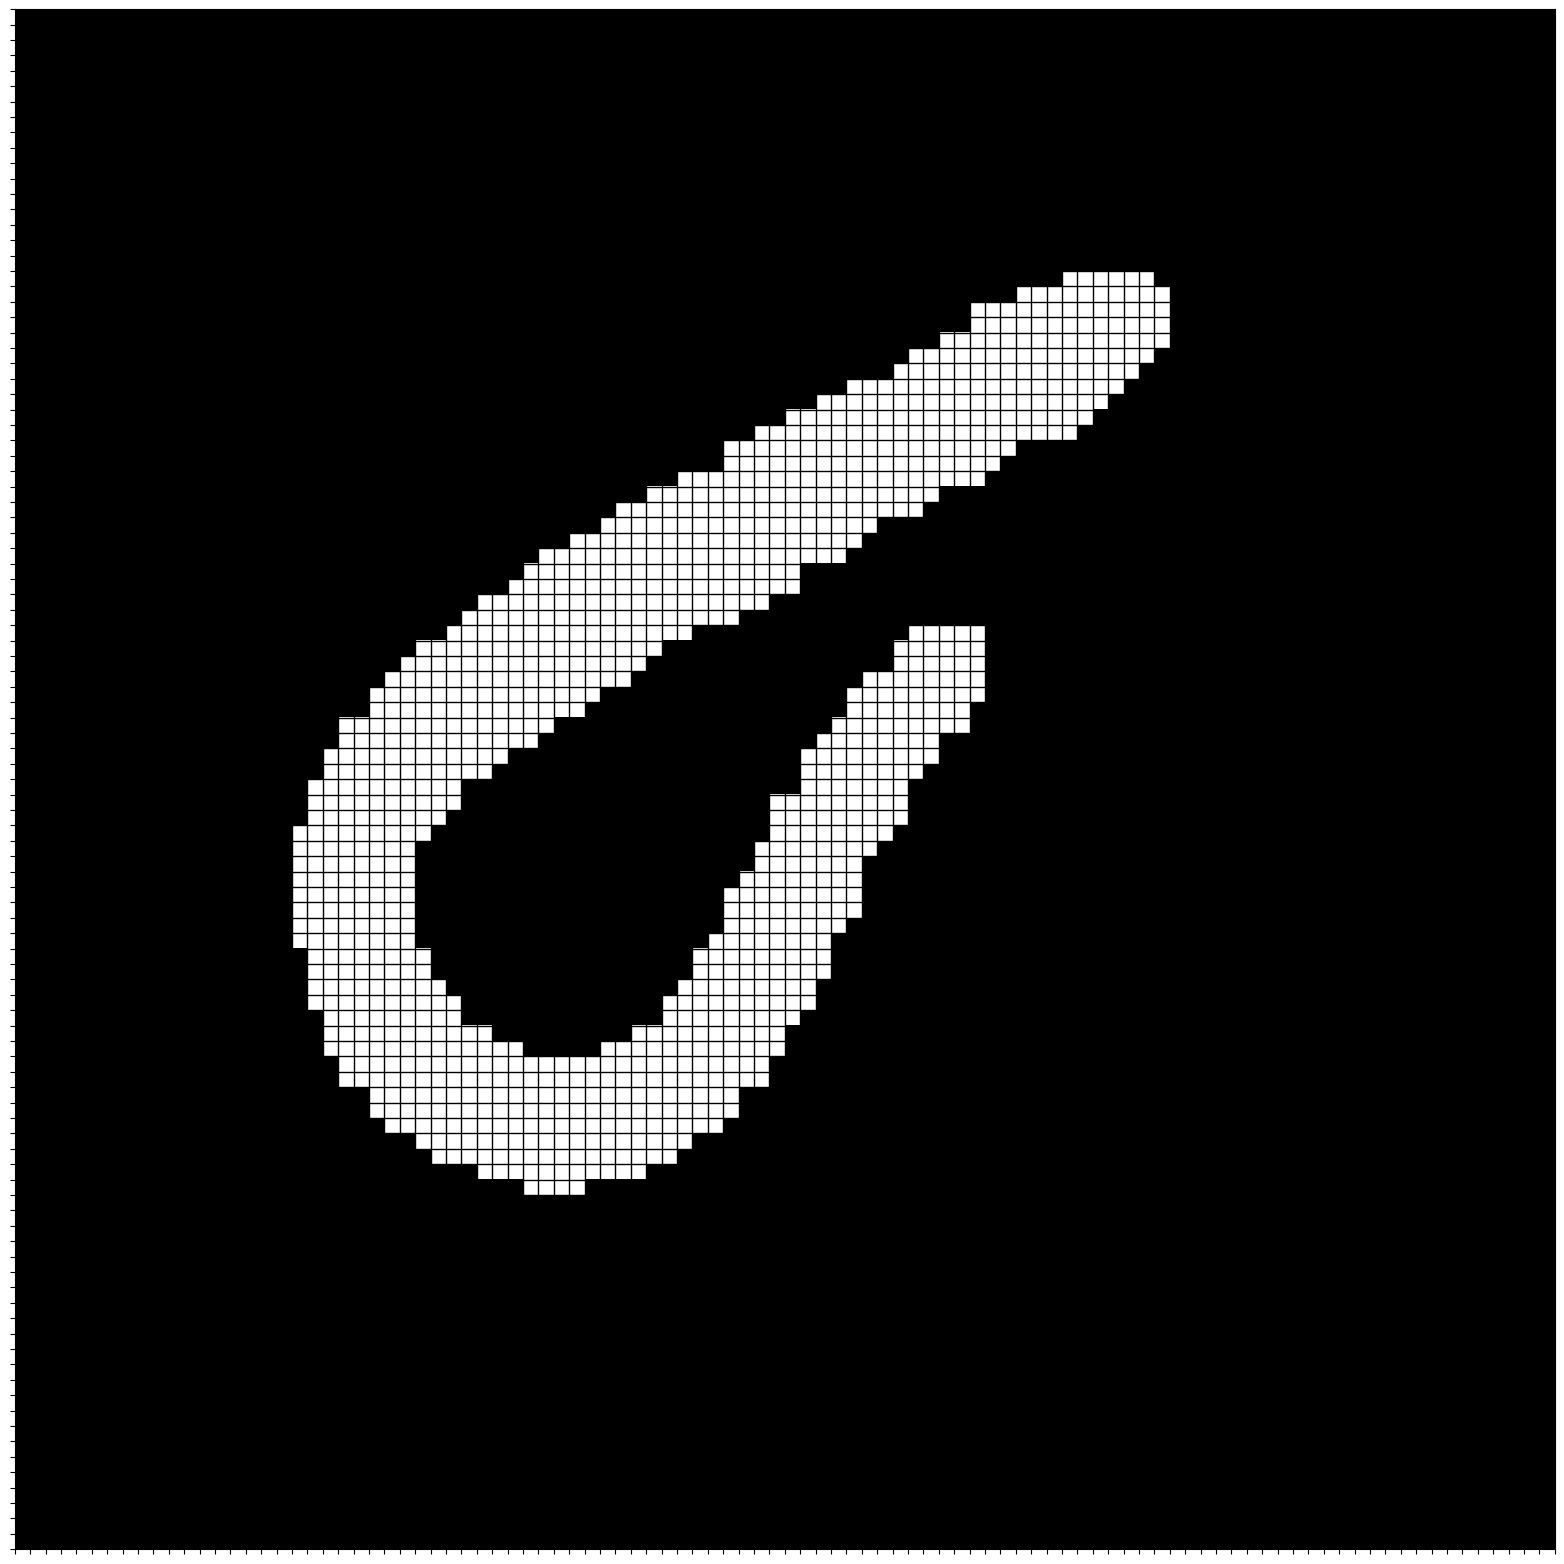

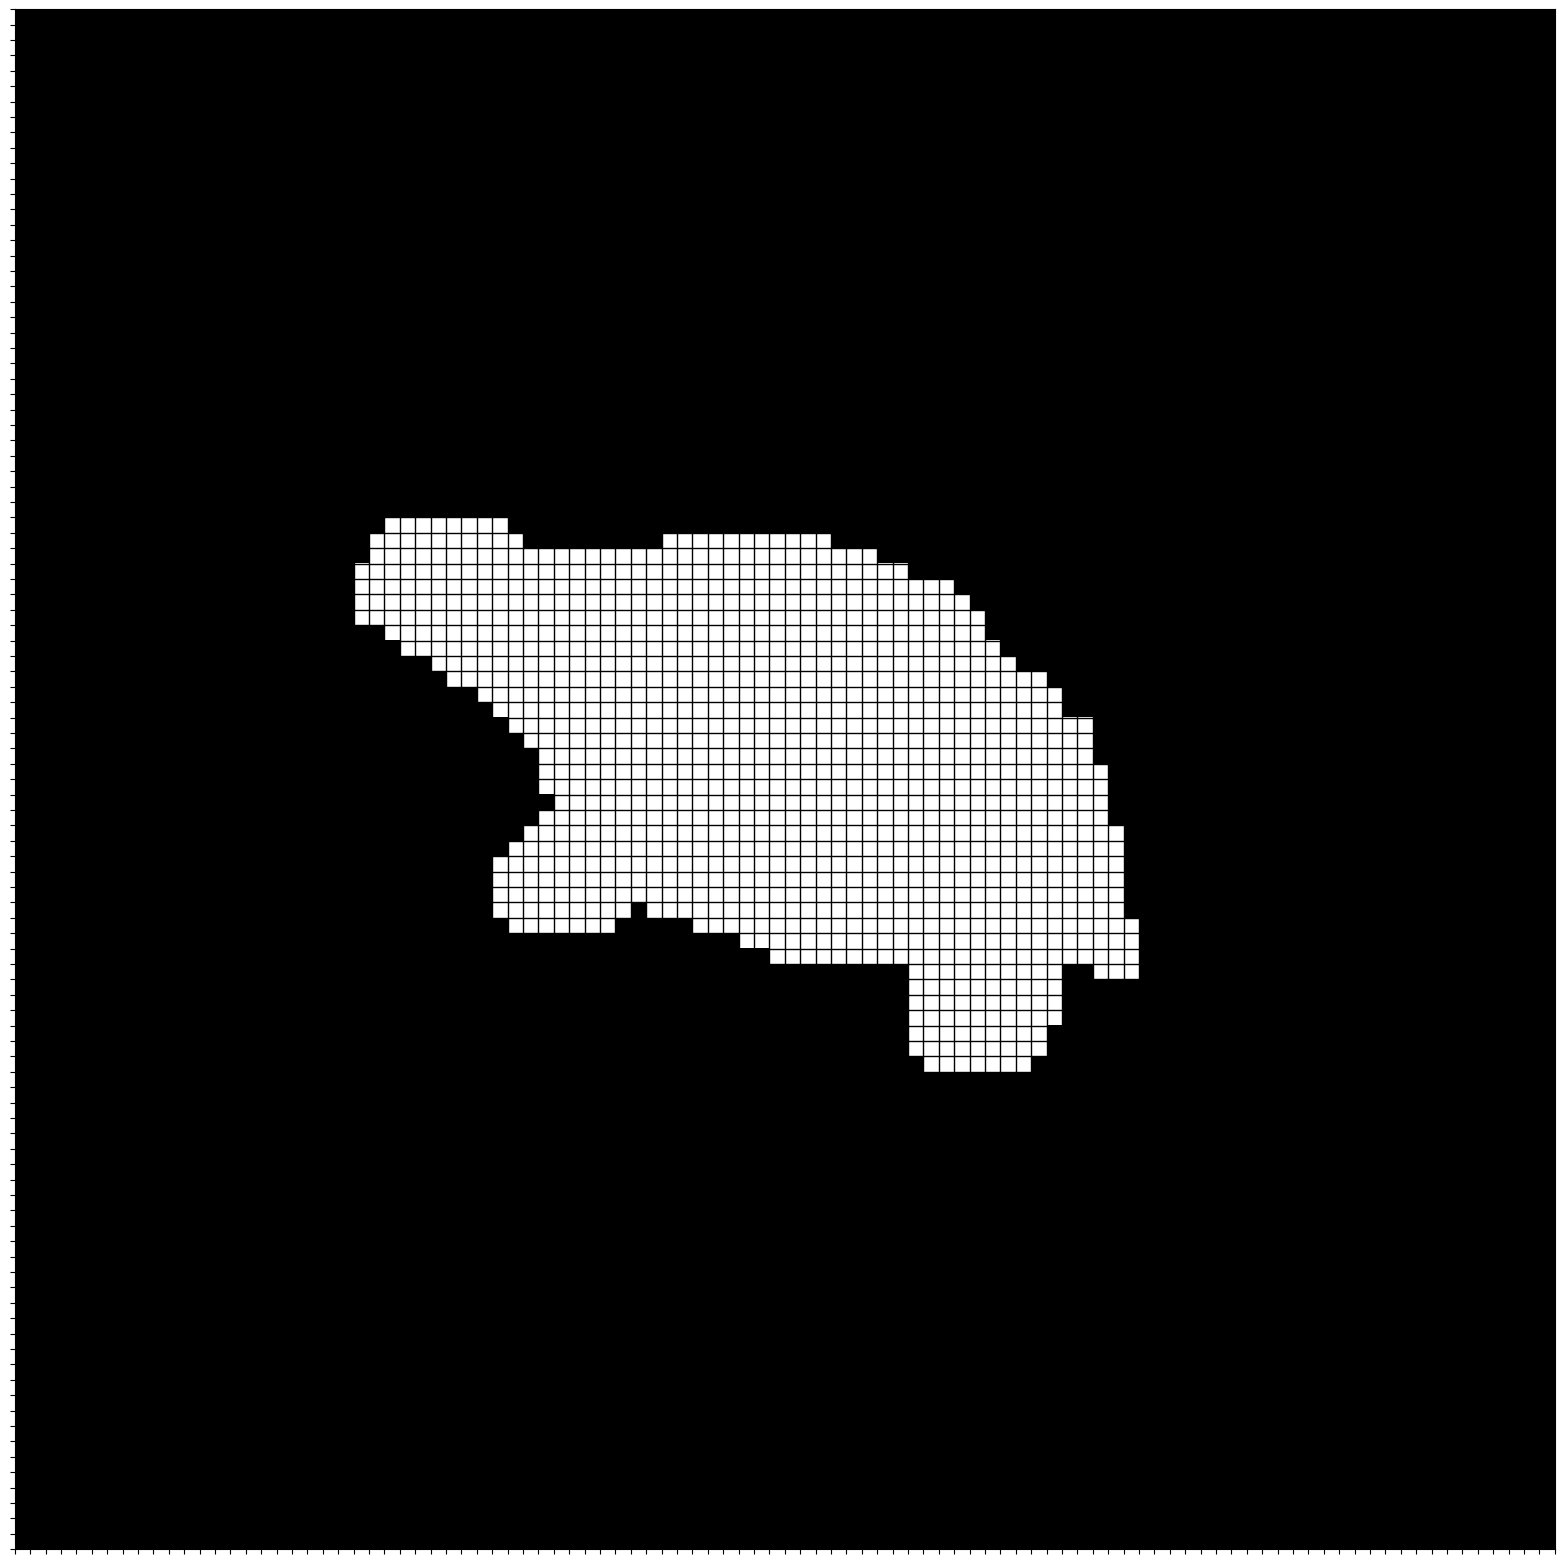

In [54]:
for image in scaled_images:
    binary_image = image

    # Configurar el tamaño de la figura y la cuadrícula
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xticks(np.arange(-0.5, binary_image.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, binary_image.shape[0], 1))
    ax.grid(which='both', color='black', linestyle='-', linewidth=1)

    # Configurar la etiqueta para los ejes x e y
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Mostrar la imagen binaria en la cuadrícula
    ax.imshow(binary_image, cmap='gray', interpolation='nearest')

    plt.show()

### 6. Obtener el contorno de cada uno de los objetos binarios, considerando la vecindad-8

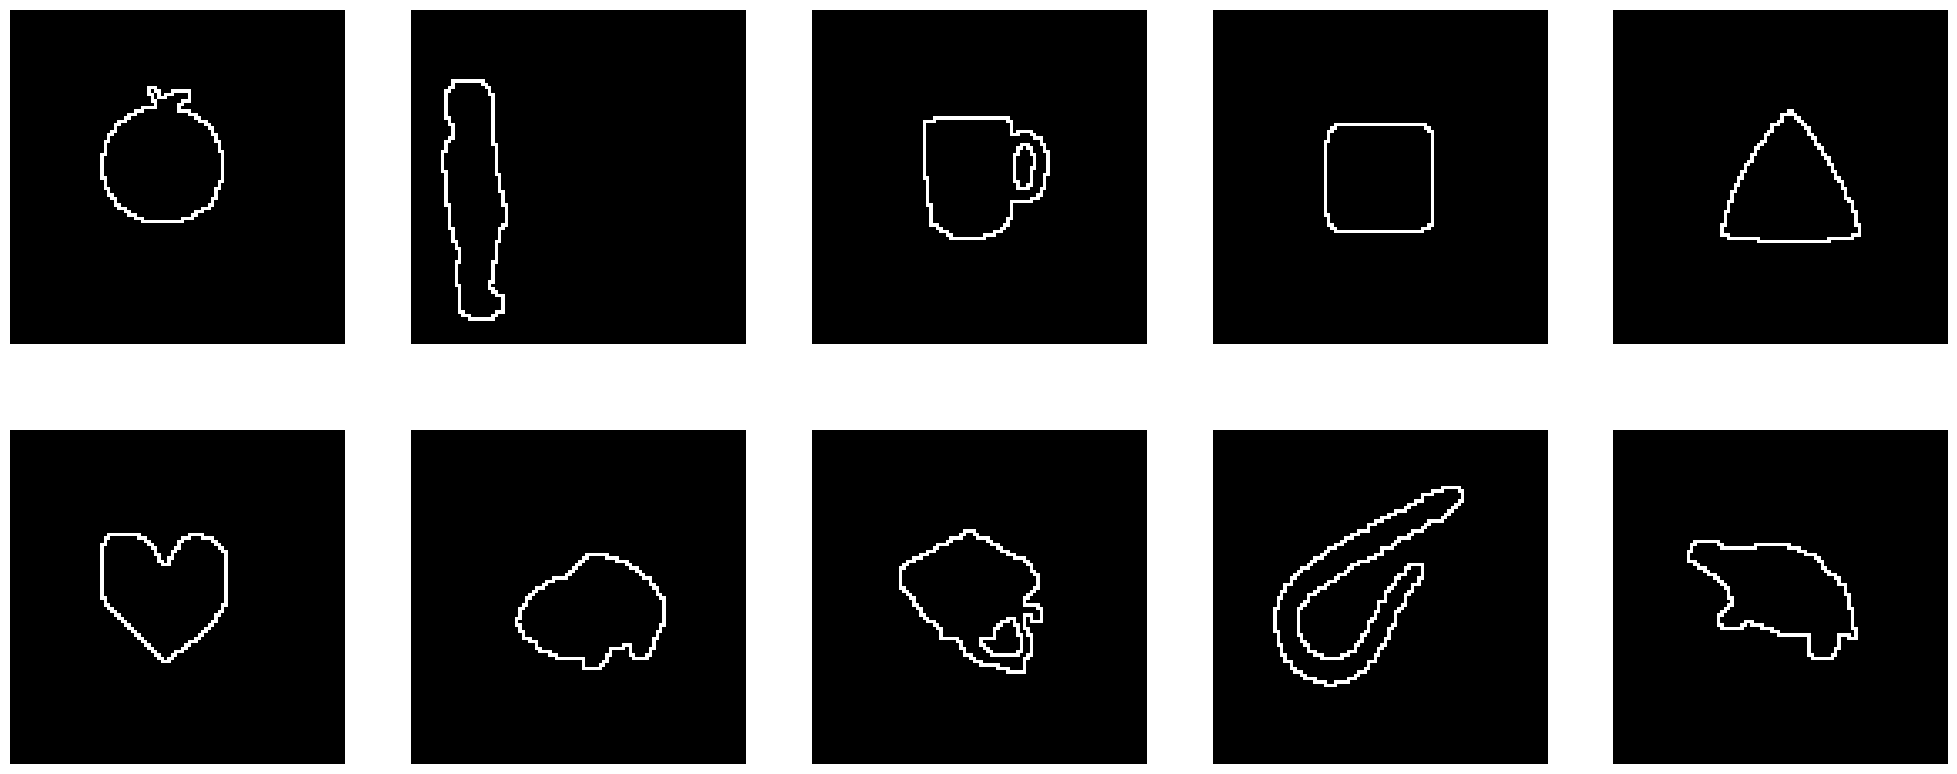

In [55]:
def get_border(image):
    binary_image = image

    border_image = np.zeros_like(binary_image)

    height, width = binary_image.shape
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            neighbors = [binary_image[i-1, j-1], binary_image[i-1, j], binary_image[i-1, j+1],
                        binary_image[i, j-1], binary_image[i, j+1],
                        binary_image[i+1, j-1], binary_image[i+1, j], binary_image[i+1, j+1]]
            if binary_image[i, j] == 1 and 0 in neighbors:
                border_image[i, j] = 1

    return border_image

bordered_images = []

for image in scaled_images:
    bordered_images.append(get_border(image))

showImages(bordered_images)

### 7. Calcular el centro de masa (𝑥𝑐𝑚, 𝑦𝑐𝑚) de cada uno de los objetos binarios. Trasladar la imagen original a una posición diferente y calcular los momentos centrales para p,q = 0,1 y 2

In [56]:
for image in scaled_images:
    print(calculate_center_of_mass(image))

(45, 45)
(18, 55)
(49, 48)
(49, 49)
(52, 54)
(45, 47)
(54, 54)
(48, 49)
(42, 47)
(49, 48)


### Trasladar

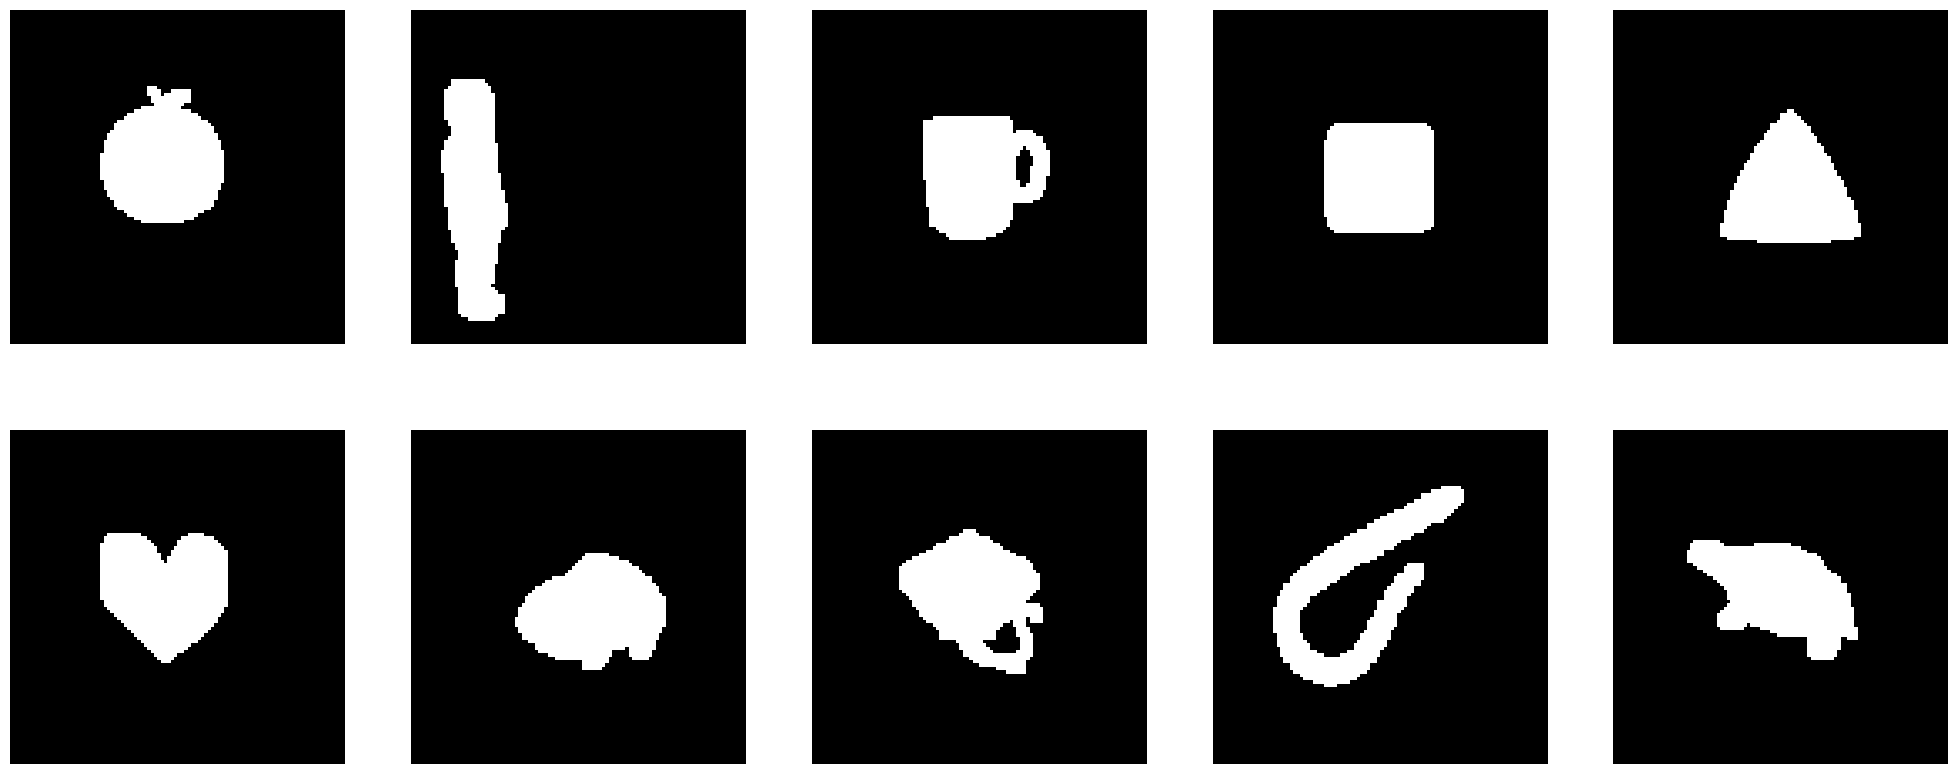

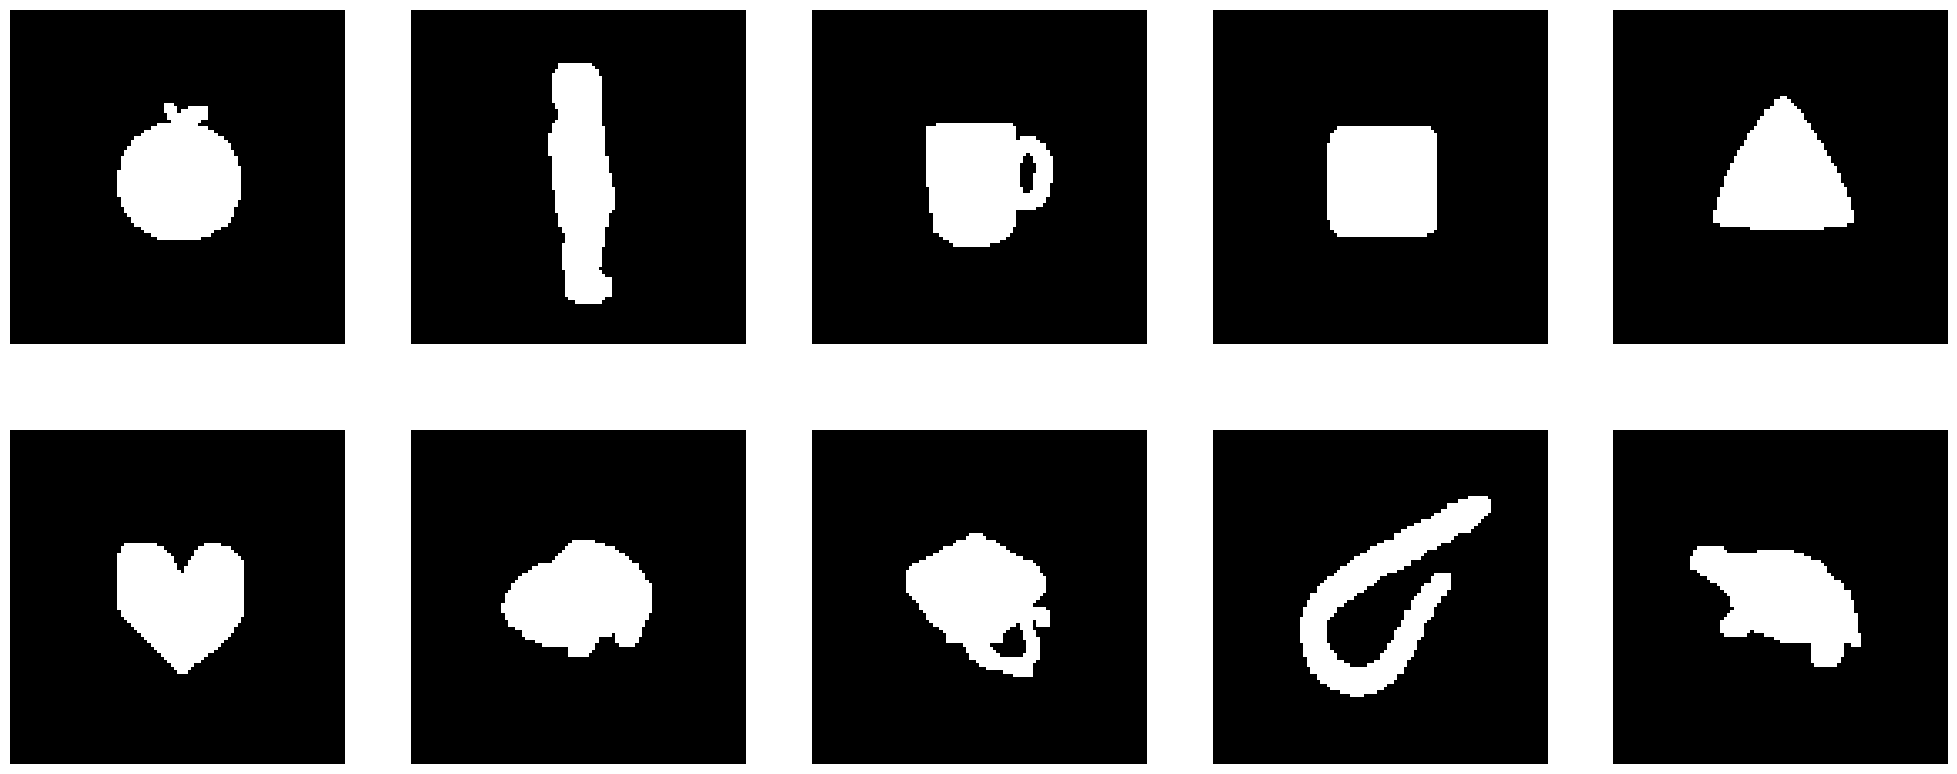

In [57]:
def translate(image, x, y):
    # Definir una imagen binarizada de ejemplo
    imagen_original = image

    # Crear un nuevo arreglo de numpy relleno con ceros
    filas, columnas = imagen_original.shape
    imagen_traslada = np.zeros((filas, columnas), dtype=np.uint8)

    # Copiar los valores de la imagen original en la posición correspondiente en el nuevo arreglo
    for i in range(filas):
        for j in range(columnas):
            if i + y < filas and j + x < columnas:
                imagen_traslada[i + y, j + x] = imagen_original[i, j]

    # Mostrar la imagen original y la imagen trasladada
    return imagen_traslada

translated_images = []

for image in scaled_images:
    Xcm, Ycm = calculate_center_of_mass(image)
    translated_images.append(translate(image, int(image.shape[1]/2 - Xcm),
                                              int(image.shape[0]/2 - Ycm)))

showImages(scaled_images)
showImages(translated_images)

### Momentos centrales

In [58]:
for i in range(len(scaled_images)):
    print('Imagen original', i + 1)
    for p in range(0, 3):
        q_values = []
        for q in range(0, 3):
            result = central_moment(scaled_images[i], p, q)
            q_values.append(result)
        print(q_values)
    print('Imagen transladada', i + 1)
    for p in range(0, 3):
        q_values = []
        for q in range(0, 3):
            result = central_moment(translated_images[i], p, q)
            q_values.append(result)
        print(q_values)
    print()

Imagen original 1
[1119, 39, 108423]
[244, -1141, 57389]
[94790, 88589, 5784807]
Imagen transladada 1
[1119, 39, 108423]
[244, -1141, 57389]
[94790, 88589, 5784807]

Imagen original 2
[1060, 545, 411121]
[353, 20918, 193948]
[22085, 2380, 7263738]
Imagen transladada 2
[1060, 545, 411121]
[353, 20918, 193948]
[22085, 2380, 7263738]

Imagen original 3
[1098, 780, 105898]
[163, -4053, -138663]
[101857, -71085, 7072945]
Imagen transladada 3
[1098, 780, 105898]
[163, -4053, -138663]
[101857, -71085, 7072945]

Imagen original 4
[1066, 1050, 94586]
[140, -84, 26314]
[93214, 90078, 7803676]
Imagen transladada 4
[1066, 1050, 94586]
[140, -84, 26314]
[93214, 90078, 7803676]

Imagen original 5
[1088, 93, 104809]
[358, 1990, 37352]
[102316, 426818, 7420292]
Imagen transladada 5
[1088, 93, 104809]
[358, 1990, 37352]
[102316, 426818, 7420292]

Imagen original 6
[1102, 409, 95689]
[768, 8258, 63502]
[114366, -257002, 7697858]
Imagen transladada 6
[1102, 409, 95689]
[768, 8258, 63502]
[114366, -257002

### 8. Para cada objeto, realizar una rotación* con un ángulo x, y calcular los tres primeros momentos de Hu, antes y después de la rotación 

$$
\begin{matrix}
\varphi_1 = \mu_{20} + \mu_{02} \\
\varphi_2 = (\mu_{20} - \mu_{02})^2 + 4\mu_{11}^2 \\
\varphi_3 = (\mu_{30} - 3\mu_{12})^2 + (3\mu_{21} - \mu_{03})^2
\end{matrix}
$$

> *Nota: para rotar los objetos binarios, aplicar la matriz de rotación vista en clase. Usar interpolación bilineal o algún filtro para rellenar los huecos que hayan quedado al rotar


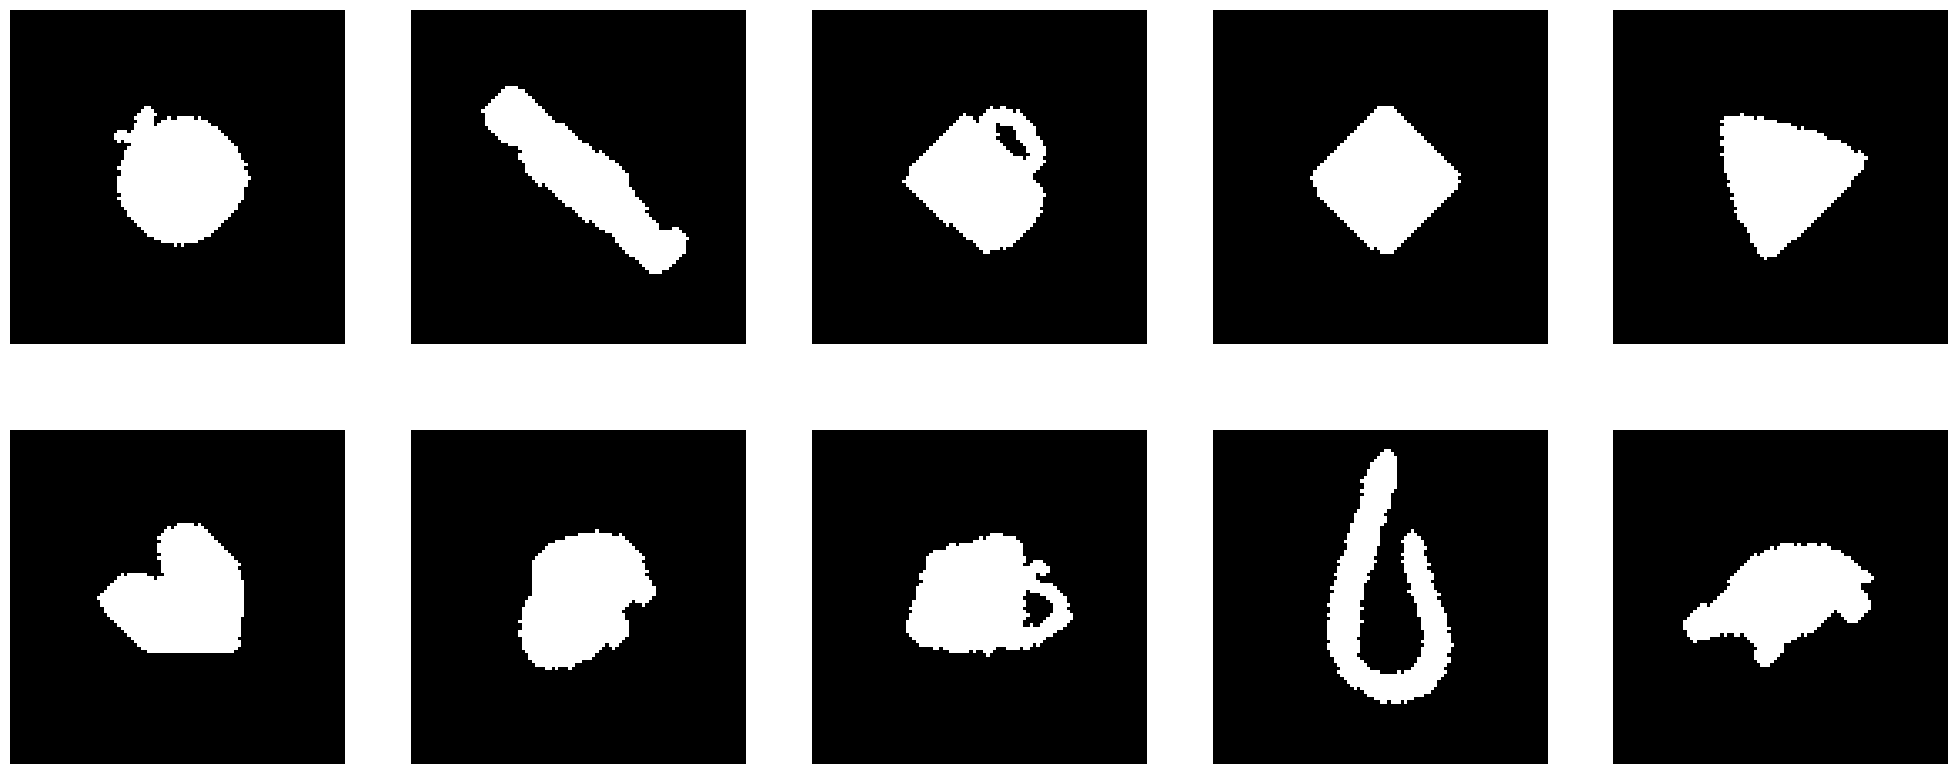

In [59]:
import numpy as np

def rotate_binary_image(image, angle_rad):
    # Obtener las dimensiones de la imagen original
    height, width = image.shape
    
    # Calcular las dimensiones de la imagen de destino
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    new_width = int(abs(width * cos_theta) + abs(height * sin_theta))
    new_height = int(abs(height * cos_theta) + abs(width * sin_theta))

    # Crear la matriz vacía de la imagen de destino
    rotated_image = np.zeros((height, width), dtype=np.uint8)

    # Calcular el centro de la imagen original
    cx = width // 2
    cy = height // 2

    # Iterar sobre cada píxel en la imagen de destino
    for x in range(width):
        for y in range(height):
            # Calcular las coordenadas del píxel en la imagen original
            tx = x - width // 2
            ty = y - height // 2
            px = int(tx * cos_theta - ty * sin_theta) + cx
            py = int(tx * sin_theta + ty * cos_theta) + cy

            # Copiar el valor del píxel de la imagen original a la imagen de destino
            if (px >= 0 and px < width and py >= 0 and py < height):
                rotated_image[y,x] = image[py,px]

    return rotated_image

rotatedImages = []
angle = 0.78539816

for image in translated_images:
    rotatedImages.append(rotate_binary_image(image,angle))

showImages(rotatedImages)

### Momentos de hu

In [60]:
def calculate_moments(image):
    # Obtener las dimensiones de la imagen
    height, width = image.shape

    # Calcular los momentos de orden cero
    m00 = np.sum(image)

    # Calcular las coordenadas del centro de masa
    xcm = np.sum(np.multiply(np.arange(width), np.sum(image, axis=0))) / m00
    ycm = np.sum(np.multiply(np.arange(height), np.sum(image, axis=1))) / m00

    # Calcular los momentos centrales
    mu20 = central_moment(image,2,0)
    mu02 = central_moment(image,0,2)
    mu11 = central_moment(image,1,1)

    # Calcular los momentos normalizados
    nu20 = normalized_moments(image,2,0)
    nu02 = normalized_moments(image,0,2)
    nu11 = normalized_moments(image,1,1)
    nu30 = normalized_moments(image,3,0)
    nu12 = normalized_moments(image,1,2)
    nu21 = normalized_moments(image,2,1)
    nu03 = normalized_moments(image,0,3)

    # Calcular los momentos de Hu
    phi1 = nu20 + nu02
    phi2 = np.power(nu20 - nu02, 2) + 4 * np.power(nu11, 2)
    phi3 = np.power(nu30 - 3 * nu12, 2) + np.power(3 * nu21 - nu03, 2)
    return phi1, phi2, phi3


for i in range(len(translated_images)):
    print("Imagen antes de rotar", i + 1)
    print(calculate_moments(translated_images[i]))
    print("Imagen despues de rotar", i + 1)
    print(calculate_moments(rotatedImages[i]))
    print()


Imagen antes de rotar 1
(0.1622898333361285, 0.0001218606666679296, 0.00010521576904975238)
Imagen despues de rotar 1
(0.16287867227738864, 0.00012288049876895177, 9.486811195657525e-05)

Imagen antes de rotar 2
(0.38555179779280885, 0.12126895384451213, 0.0014466178555052598)
Imagen despues de rotar 2
(0.369390362502622, 0.10902593681330515, 0.001268064777562457)

Imagen antes de rotar 3
(0.17232441166419488, 5.644168498121195e-05, 0.0005249220742680297)
Imagen despues de rotar 3
(0.17225603526338923, 3.394318146681843e-05, 0.0004406480595628821)

Imagen antes de rotar 4
(0.16526511058154308, 1.4795947208862416e-06, 1.5019135717368843e-06)
Imagen despues de rotar 4
(0.1653278553795975, 4.0805868414478115e-06, 1.8391306064630396e-06)

Imagen antes de rotar 5
(0.17497448772707613, 1.573984031569003e-05, 0.001832311608492171)
Imagen despues de rotar 5
(0.17496630486134163, 2.418930921855025e-05, 0.0017086020885588387)

Imagen antes de rotar 6
(0.17296962131218277, 0.000421493251723456, 0

### 9. Calcular los ejes principales de cada uno de los objetos y alinearlos en una misma dirección, por ejemplo, el eje Y

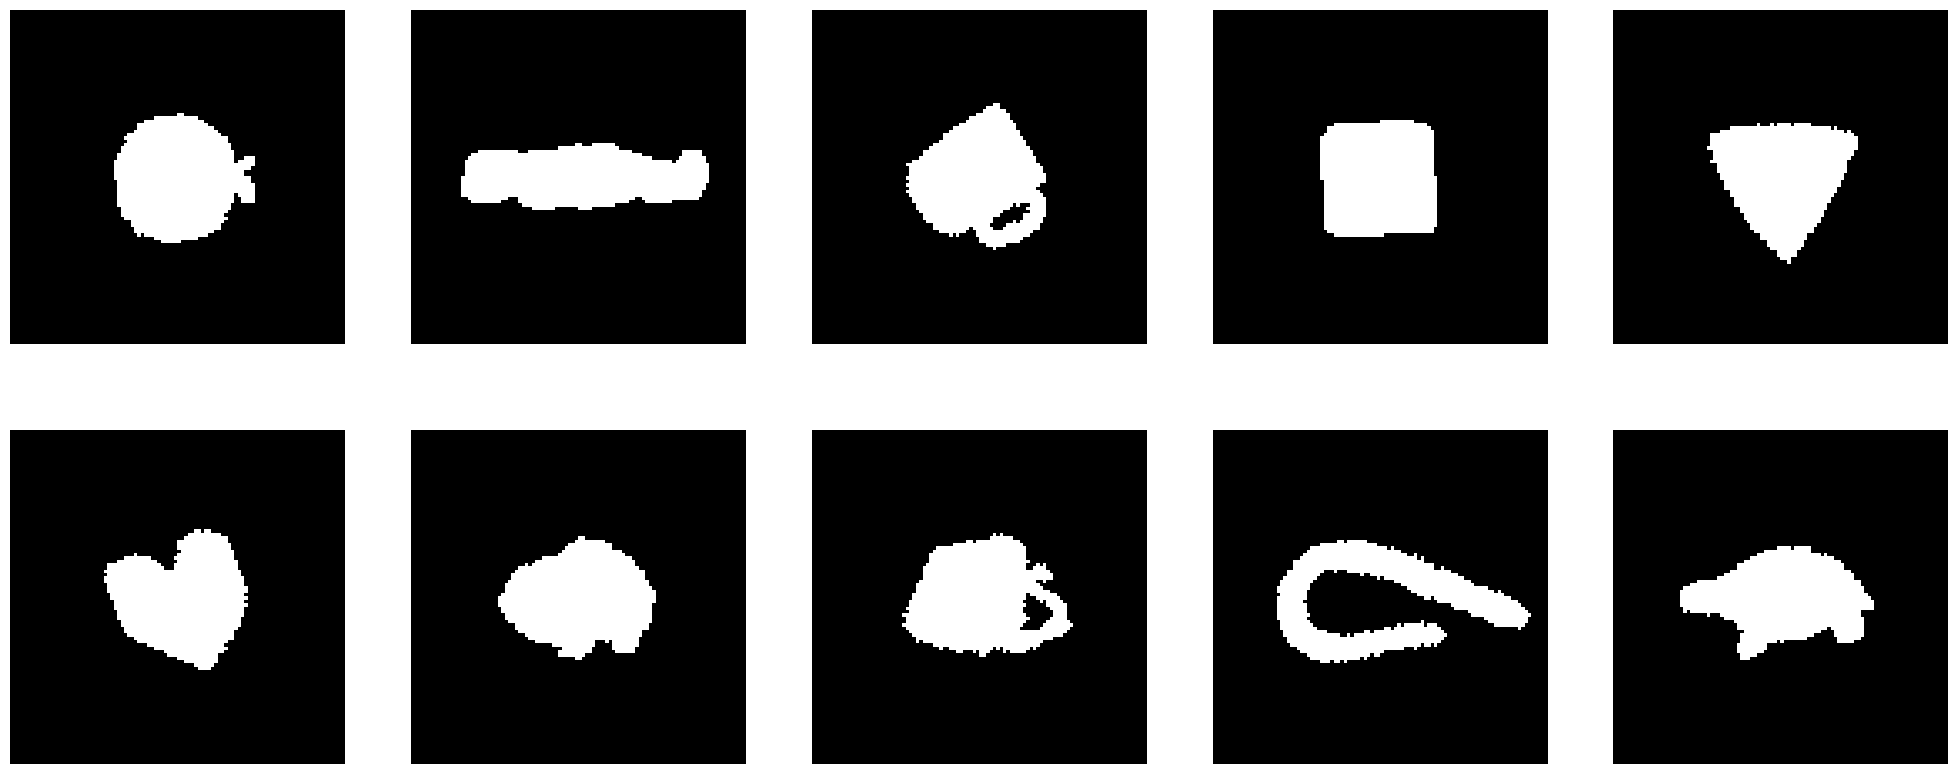

In [61]:
def moment_matrix(image):
    return np.array([[central_moment(image, 2, 0), central_moment(image, 1, 1)],
            [central_moment(image, 1, 1), central_moment(image, 0, 2)]])

def align_to_x_axis(moment_mat):
    # Calculate the moments of the image with respect to the centroid
    u20 = moment_mat[0, 0]
    u11 = moment_mat[0, 1]
    u02 = moment_mat[1, 1]
    
    # Add a small epsilon value to avoid division by zero
    eps = 1e-8

    # Calculate the angle to align with the X axis
    phi = 0.5 * np.arctan2(2 * u11, u20 - u02 + eps)

    return phi

second_rotated_images = []

for image in translated_images:
    second_rotated_images.append(rotate_binary_image(image, align_to_x_axis(moment_matrix(image))))

showImages(second_rotated_images)

### 10. Realizar una superposición entre cada pareja de objetos haciendo coincidir el centro de masa. En una tabla de 10 × 10 indicar el número de pixeles comunes (𝑃𝑐) y pixeles no comunes, 𝑃+ y 𝑃−, respectivamente, entre los 10 objetos. 

In [62]:
common_pixels = np.zeros((len(rotatedImages), len(rotatedImages)))

for i in range(len(rotatedImages)):
    for j in range(len(rotatedImages)):
        intersection = np.logical_and(rotatedImages[i], rotatedImages[j])
        common_pixels[i,j] = np.sum(intersection)

print(common_pixels)


[[1187.  677. 1017. 1066. 1047. 1008. 1029. 1010.  529.  911.]
 [ 677. 1145.  655.  602.  665.  599.  581.  650.  384.  511.]
 [1017.  655. 1181. 1015.  926. 1020.  976.  970.  483.  855.]
 [1066.  602. 1015. 1149.  980. 1012.  993.  972.  479.  918.]
 [1047.  665.  926.  980. 1163.  902.  994.  942.  496.  911.]
 [1008.  599. 1020. 1012.  902. 1171.  965.  994.  513.  891.]
 [1029.  581.  976.  993.  994.  965. 1182. 1008.  546.  924.]
 [1010.  650.  970.  972.  942.  994. 1008. 1219.  508.  944.]
 [ 529.  384.  483.  479.  496.  513.  546.  508. 1153.  421.]
 [ 911.  511.  855.  918.  911.  891.  924.  944.  421. 1158.]]


In [63]:
P_plus = []
P_minus = []

for i in range(len(common_pixels)):
    P_Plus_i = []
    P_Minus_i = []
    for j in range(i, len(common_pixels)):
        P_Plus_i.append(int(common_pixels[i][i] - common_pixels[i][j]))
        P_Minus_i.append(int(common_pixels[j][j] - common_pixels[i][j]))
    P_plus.append(P_Plus_i)
    P_minus.append(P_Minus_i)

print("P+")
tabla_pixeles = pd.DataFrame.from_records(P_plus)
display(tabla_pixeles)
print()
print("P-")
tabla_pixeles = pd.DataFrame.from_records(P_minus)
display(tabla_pixeles)

P+


,0,1,2,3,4,5,6,7,8,9
0,0,510.0,170.0,121.0,140.0,179.0,158.0,177.0,658.0,276.0
1,0,490.0,543.0,480.0,546.0,564.0,495.0,761.0,634.0,NaN
2,0,166.0,255.0,161.0,205.0,211.0,698.0,326.0,NaN,NaN
3,0,169.0,137.0,156.0,177.0,670.0,231.0,NaN,NaN,NaN
4,0,261.0,169.0,221.0,667.0,252.0,NaN,NaN,NaN,NaN
5,0,206.0,177.0,658.0,280.0,NaN,NaN,NaN,NaN,NaN
6,0,174.0,636.0,258.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,711.0,275.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



P-


,0,1,2,3,4,5,6,7,8,9
0,0,468.0,164.0,83.0,116.0,163.0,153.0,209.0,624.0,247.0
1,0,526.0,547.0,498.0,572.0,601.0,569.0,769.0,647.0,NaN
2,0,134.0,237.0,151.0,206.0,249.0,670.0,303.0,NaN,NaN
3,0,183.0,159.0,189.0,247.0,674.0,240.0,NaN,NaN,NaN
4,0,269.0,188.0,277.0,657.0,247.0,NaN,NaN,NaN,NaN
5,0,217.0,225.0,640.0,267.0,NaN,NaN,NaN,NaN,NaN
6,0,211.0,607.0,234.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,645.0,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,737.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 11. Con el Algoritmo Húngaro, mover los pixeles 𝑃+ a los pixeles 𝑃− y realizar una tabla de las distancias mínimas obtenidas al comparar cada pareja de objetos.

In [64]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Ejemplo de matriz de costos
cost_matrix = np.array([[9, 7, 8, 6],
                       [6, 5, 3, 2],
                       [8, 8, 6, 8],
                       [10, 6, 9, 5]])

# Función para resolver el problema de asignación utilizando el algoritmo húngaro
def hungarian_algorithm(cost_matrix):
    # Encontrar la asignación óptima de costos
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    return row_ind, col_ind, total_cost

# Llamar a la función y obtener los resultados
row_ind, col_ind, total_cost = hungarian_algorithm(cost_matrix)

# Imprimir los resultados
print("Asignación óptima:")
for i in range(len(row_ind)):
    print("Tarea {} asignada a Trabajador {}".format(row_ind[i], col_ind[i]))
print("Costo total de asignación: {}".format(total_cost))


Asignación óptima:
Tarea 0 asignada a Trabajador 1
Tarea 1 asignada a Trabajador 2
Tarea 2 asignada a Trabajador 0
Tarea 3 asignada a Trabajador 3
Costo total de asignación: 23


In [65]:
def min_distance(img1, img2):
    p_plus = np.argwhere(np.logical_and(img1 == 1, img2 == 0))  # Pixeles P+
    p_minus = np.argwhere(np.logical_and(img1 == 0, img2 == 1))  # Pixeles P-

    n_plus = len(p_plus)
    n_minus = len(p_minus)

    if n_plus == 0 or n_minus == 0:
        return 0

    # Calculamos la matriz de costos
    cost_matrix = np.zeros((n_plus, n_minus))
    for i in range(n_plus):
        for j in range(n_minus):
            cost_matrix[i][j] = np.linalg.norm(p_plus[i] - p_minus[j])

    # Resolvemos el problema de asignación usando el algoritmo húngaro
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Retornamos la suma de los costos mínimos
    return cost_matrix[row_ind, col_ind].sum()

costs = np.zeros((10, 10))

for i in range(len(second_rotated_images)):
    for j in range(i, (len(second_rotated_images))):
        costs[i, j] = int(min_distance(second_rotated_images[i], second_rotated_images[j]))

for cost in costs:
    print(list(cost))

[0.0, 10339.0, 1377.0, 717.0, 1851.0, 1937.0, 1820.0, 1505.0, 10027.0, 3764.0]
[0.0, 0.0, 10583.0, 10655.0, 10906.0, 10170.0, 8862.0, 8714.0, 6455.0, 6765.0]
[0.0, 0.0, 0.0, 1268.0, 2869.0, 2284.0, 1937.0, 1242.0, 10601.0, 4023.0]
[0.0, 0.0, 0.0, 0.0, 1991.0, 2118.0, 2048.0, 1080.0, 10052.0, 4034.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 2209.0, 2805.0, 2462.0, 10727.0, 4549.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2083.0, 2090.0, 10734.0, 3782.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1013.0, 9461.0, 2196.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8822.0, 2388.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8255.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 12. Analizar cada uno de los resultados y obtener conclusiones. En las conclusiones aclarar si las ecuaciones (1), (2) y (3) son invariantes ante dichas transformaciones y si el método de escalamiento, alineación por ejes principales y aplicación del Algoritmo Húngaro para mover los pixeles, es adecuado para dar una medida de similitud.